# I’m Something of a Painter Myself

## Introduction

**Project Description**

1. What type of data is been used in this project?

    In this project, we will be using image data, a part of the Kaggle competition ["I’m Something of a Painter Myself"](https://www.kaggle.com/competitions/gan-getting-started/overview). The competition provides 4 directories seperated into two parts 1st part contains monets painting in JPEG and tfrec format and the 2nd part contains normal images in JPEG and tfrec format. They have also mentioned the data distrbution which is as follows:
    
   * **monet_jpg** - 300 Monet paintings sized 256x256 in JPEG format
   * **monet_tfrec** - 300 Monet paintings sized 256x256 in TFRecord format
   * **photo_jpg** - 7028 photos sized 256x256 in JPEG format
   * **photo_tfrec** - 7028 photos sized 256x256 in TFRecord format
    
2. What type of problem we are solving in this project?

    In this project we will be implementing Generative Adversarial Networks(GANs), a unsupervised neural network algorithm architecture in the field of computer vision. GANs are based on a simple concept to generate similar but fake data out of the real/original data. Recently, GANs have become the best method in mimicking objects in a very convincing way. 

   * **Challenge** - Task for this project is to generate fake images of the monet style paintings, the number of images needed to qualify are in between 7000 to 10000 images.
   * **Methodology** - We will be using the Deep Convolutional Generative Adversarial Network(DCGAN) architecture, as in the name we will be using convolutional layers in our neural networks. This methodology is the basic among the different types of GANs, understanding and implementing this architecture gives a strong foundation in GANs. PyTorch has a great tutorial on DCGAN, [check this tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) for much more indepth learning.

## Importing Libraries

In [1]:
# Importing all the necessary libraries

# Installing modules that are not pre-installed
!pip install opendatasets --upgrade --quiet
!pip install wandb --upgrade --quiet

import os
from pathlib import Path
import shutil
from tqdm import tqdm
import opendatasets as od
import numpy as np
import cv2
import wandb
wandb.login()

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid, save_image

wandb: Currently logged in as: johnpinto. Use `wandb login --relogin` to force relogin


## Getting the data

We will be downloading the Kaggle competetion dataset using the opendatasets library. Opendatasets uses the Kaggle official API for downloading the datasets from the kaggle.

While downloading the dataset using the opendatasets library, you will need to input your username and key from kaggle.json file or you can upload the file and it will automatically read the credentials and start the download.

In [2]:
# Downloading the dataset
data_dir = Path('data')
if data_dir.exists():
    print('[INFO] Data directory exists, skipping the download.')
else:
    # Creating a data directory
    data_dir.mkdir(parents=True, exist_ok=True)
    od.download_kaggle_dataset(dataset_url='https://www.kaggle.com/competitions/gan-getting-started/data',
                               data_dir=data_dir)

[INFO] Data directory exists, skipping the download.


In [3]:
# Defining the image directory
monet_image_data = Path('data/monet_data')
photo_image_data = Path('data/photo_data')

# Moving the directory
if monet_image_data.exists() and photo_image_data.exists():
    print('[INFO] Image directory for monet and photos exist, skipping the move command.')
else:
    print(f'[INFO] Moving the images in seperate directory. Monet Images: {monet_image_data} and Photo Images: {photo_image_data}')
    # Moving images into images sub-directory, this will be consider as a class in the ImageFolder function.
    shutil.move('data/gan-getting-started/monet_jpg', monet_image_data / 'images')
    shutil.move('data/gan-getting-started/photo_jpg', photo_image_data / 'images')

[INFO] Image directory for monet and photos exist, skipping the move command.


In [4]:
# Checking the files in the data directory
print(f'Monet image directory: {monet_image_data}')
print(f'Photo image directory: {photo_image_data}')
print(f'Number of images in the monet directory: {len(os.listdir(monet_image_data / "images"))}')
print(f'Number of images in the photo directory: {len(os.listdir(photo_image_data / "images"))}')

Monet image directory: data/monet_data
Photo image directory: data/photo_data
Number of images in the monet directory: 300
Number of images in the photo directory: 7038


### Creating Dataset and DataLoader

We will load the dataset using the ImageFolder class from torchvision. We will also apply transforms like Resize, CenterCrop and normalize the image at 0.5 for mean and standard deviation. This will make sure that we recive the data in the range of -1 and 1 which is best for training the models. Finally, we create the dataloader to load the data in the form of batches.

In [5]:
# Creating a helper function for random seed
def seed(n: int=42):
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
seed(42)

In [6]:
# input values
image_size = 64
batch_size = 16
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
workers = os.cpu_count()

# Creating dataset
dataset = ImageFolder(root=monet_image_data,
                      transform=transforms.Compose([
                          transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=mean, std=std)
                      ]))

# Creating dataloader
seed(42)
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=workers,
                        pin_memory=True)

print('Images in dataset:', len(dataset), 'and Batch in dataloader:', len(dataloader))

Images in dataset: 300 and Batch in dataloader: 19


In [7]:
# Creating device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

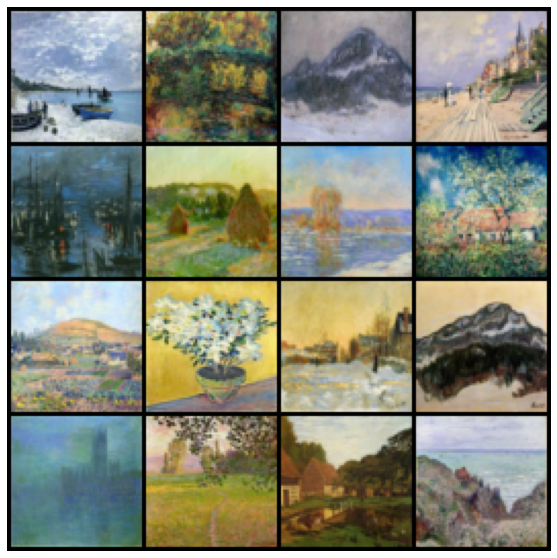

In [8]:
# Creating a helper function to plot images in grid
def plot_grid_images(images, nmax=16, nrow=4):
    plt.figure(figsize=(10, 10))
    plt.imshow(make_grid(images.to(device)[:nmax], nrow=nrow, normalize=True).permute(1, 2, 0).cpu())
    plt.axis(False)
    
def plot_dataloader_images(dataloader, nmax=16, nrow=4):
    images,_ = next(iter(dataloader))
    plot_grid_images(images=images, nmax=nmax, nrow=nrow)
    
plot_dataloader_images(dataloader)

## Modeling

Now, that we have our dataset and dataloaders ready for the experiment, we can move forward and work on the modeling.

![](https://machinelearningmastery.com/wp-content/uploads/2019/04/Example-of-the-Generative-Adversarial-Network-Model-Architecture.png)

*GANs Architecture*

GANs are based on two different models namely Discriminator and Generator. The Generator generates 'Fake' samples out of a random vector or matrix and the Discriminator attempts to detects whether the given sample is 'Real' or 'Fake'. We train both the models and make them work together, this in exchange helps the Generator to create samples that can be exceptionally good and outsmart the Discriminator.

### Discrimination Architecture

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [9]:
# Creating discrimination network architecture
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            # in: 3 X 64 X 64
            nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 X 32 X 32
            
            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 X 16 X 16
            
            nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 X 8 X 8
            
            nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 X 4 X 4
            
            nn.Conv2d(conv_dim*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 X 1 X 1
            
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

# Creating discriminator model
seed(42)
discriminator_model = Discriminator().to(device)
discriminator_model

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

In [10]:
discriminator_model(torch.rand(16, 3, 64, 64, device=device)).shape

torch.Size([16, 1])

### Generator Architecture

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 256 x 256. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution). 

In [11]:
# Creating Generator architecture
class Generator(nn.Module):
    def __init__(self, latent_size: int, conv_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            # in: latent_size X 1 X 1         
            nn.ConvTranspose2d(latent_size, conv_dim*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(conv_dim*8),
            nn.ReLU(inplace=True),
            # out: 512 X 4 X 4
            
            nn.ConvTranspose2d(conv_dim*8, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4),
            nn.ReLU(inplace=True),
            # out: 256 X 8 X 8
            
            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            # out: 128 X 16 X 16
            
            nn.ConvTranspose2d(conv_dim*2, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(inplace=True),
            # out: 64 X 32 X 32
            
            nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 X 64 X 64
        )
    def forward(self, input):
        return self.main(input)

# Creating the Generator model
seed(42)
# Using latent size of 128
latent_size = 128
generator_model = Generator(latent_size).to(device)
generator_model

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

**Note:** Since, we are using TanH activation in the Generator model the output values will lie in the range [-1,1], we have applied the similar transformation to the images in the training dataset. 

Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([16, 3, 64, 64])


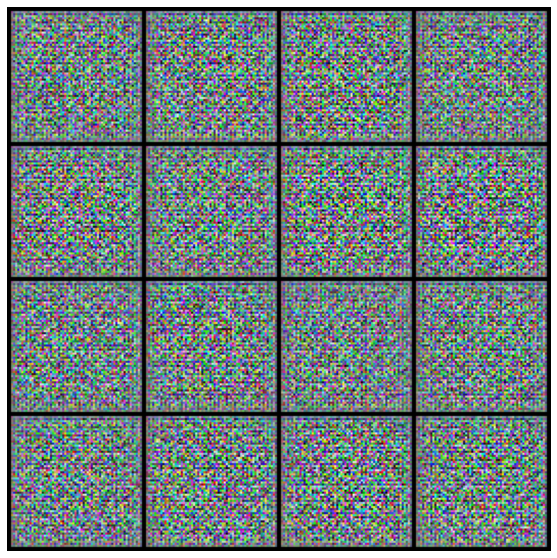

In [12]:
# Apply random tensor of latent size to the generator model
seed(42)
x = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_image = generator_model(x)
print(fake_image.shape)
plot_grid_images(images=fake_image)

The output from the generator are random noices, because we haven't trained the model.

Once we train the model, this same random tensors will result in magic.

### Discriminator Training

The Discriminator is a binary classification model, so we can use the binary cross entropy for the loss function and know how well does the model differentiate between real and fake images.

In [13]:
# Creating a function for training the discriminator model
def train_discriminator(real_images, loss_fn, dis_opt):
    # Clear gradients
    dis_opt.zero_grad()
    
    # Passing real images into the discriminator model
    real_preds = discriminator_model(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = loss_fn(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generating Fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_model(latent)
    
    # Passing fake images into the discriminator model
    fake_preds = discriminator_model(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = loss_fn(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update the discriminator weights using the optimizer
    loss = real_loss + fake_loss
    loss.backward()
    dis_opt.step()
    return loss.item(), real_score, fake_score

Discriminator training explaination:

 1. We pass the real images to the discriminator and labels of ones as a ground truth to the loss function, we expect the discriminator to learn the real images.
 2. We then generate a batch of fake images and labels of zeros as a ground truth to the loss function, here we expect the discriminator to learn the generated images are fake.
 3. Next we add the losses of fake and  real for which we perform gradient decent using the overall loss and adjust the weights of the model.

**Note:** We donot change the weights of the generator model, weights of discriminator model are only used durning gradient decent.

### Generator Training

In generator training, the only task is to create images that are similar or better than the real images and this real-like images should be capable to fool the discriminator. 

In [14]:
# Creating a function for training the generator model
def train_generator(loss_fn, gen_opt):
    # Clear gradients
    gen_opt.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_model(latent)
    
    # Passing the images to discriminator model
    preds = discriminator_model(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = loss_fn(preds, targets)
    
    # Update the generator weights unsing the optimizer
    loss.backward()
    gen_opt.step()
    return loss.item()

Generator training explaination:

 1. We first generate a batch of random latent images of the given latent size, pass it to the model and the model generates fake images.
 2. We then pass the fake images to the discriminator model and perform the loss with the labels of torch.ones, this indicates that we are fooling the discriminator by letting it know that the images generated by the generator are not fake images, afterall the objective of the generator is to fool the discriminator.
 3. Then using the loss values we perform gradient decent and adjust the weights of the generator model. This method helps in improving the model to create images that are similar to real images.

In [15]:
# creating a folder to contain all the images generated by the Generator
generator_img_dir = Path('generated')
if generator_img_dir.exists():
    print('[INFO] Generator image directory already exist.')
else:
    generator_img_dir.mkdir(parents=True, exist_ok=True)

[INFO] Generator image directory already exist.


In [16]:
# Creating a helper function that saves output of generated images
def save_generated_samples(index, latent_tensor, show=True, nrow=4, nmax=16):
    fake_images = generator_model(latent_tensor)
    fake_file_name = f'generated_images_{index:0=4d}.jpg'
    save_image(tensor=fake_images[:nmax], fp=generator_img_dir / fake_file_name, normalize=True, nrow=nrow)
    print(f'Saving {fake_file_name}\n')
    if show:
        plt.figure(figsize=(8, 8))
        plot_grid_images(images=fake_images, nrow=nrow, nmax=nmax)

We'll save a image using random tensor and check whether the helper function works the way we want.

Saving generated_images_0000.jpg



<Figure size 576x576 with 0 Axes>

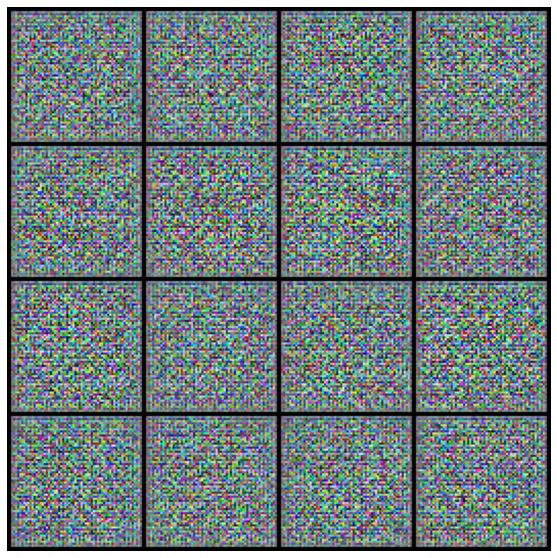

In [17]:
# Testing the helper function to save generated samples
random_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
save_generated_samples(0, random_latent)

### Training loop

We will now start training our Discriminator model and Generator Model for each batch of data. 

The training flow will be initialized by Discriminator and follwing along with Generator, this way the Discriminator will help the Generator in creating perfect images. 

We will also be using the Adam optimizer and Binary Cross Entropy Loss, and after every epochs we will also save some samples of generated images, this images will be helpful for model inspection. 

Also durning the model training, we will use Weights and Biases to track our training.

In [18]:
# Creating a fit function for training the model
def fit(epochs, lr, beta1, device, batch_size, start_idx=1):
    # Initiating weight and biases for tracking model gradient
    run = wandb.init(project='I’m Something of a Painter Myself',
                     config={'learning_rate': lr,
                             'epochs': epochs,
                             'batch_size': batch_size,
                             'loss_function': 'binary_cross_entropy',
                             'optimizer': 'adam',
                             'architecture': 'CNN'})
    run.watch(models=(discriminator_model, generator_model))
    # Clearing GPU cache
    torch.cuda.empty_cache()
    
    # list for losses and scores
    gen_losses = []
    dis_losses = []
    real_scores = []
    fake_scores = []
    
    # Creating optimizer and loss
    loss_fn = nn.BCELoss()
    dis_opt = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, 0.999))
    gen_opt = torch.optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Starting the model training
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            # Train discriminator model
            dis_loss, real_score, fake_score = train_discriminator(real_images=real_images, loss_fn=loss_fn, dis_opt=dis_opt)
            # train generator model
            gen_loss = train_generator(loss_fn=loss_fn, gen_opt=gen_opt)
        
        # Logging the metrics to weights and biases
        run.log({'Epoch': epoch+1, 'dis_loss': dis_loss, 'gen_loss': gen_loss, 'real_score': real_score, 'fake_score': fake_score})
        
        # Record losses and scores
        gen_losses.append(gen_loss)
        dis_losses.append(dis_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Display losses and scores for every epoch
        print(f'Epoch: [{epoch+1}/{epochs}] | dis_loss: {dis_loss:.4f} | gen_loss: {gen_loss:.4f} | real_score: {real_score:.4f} | fake_score: {fake_score:.4f}')
        
        # Save generated image
        random_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        save_generated_samples(index=epoch+start_idx, latent_tensor=random_latent, show=False)
    run.finish()
    return dis_losses, gen_losses, real_scores, fake_scores

We are now all set to train the model.

In [19]:
# inputs for training model
epochs = 500
lr = 0.0002
beta1 = 0.5
history = fit(epochs=epochs, lr=lr, beta1=beta1, device=device, batch_size=batch_size)

100%|██████████| 19/19 [00:01<00:00, 15.08it/s]


Epoch: [1/500] | dis_loss: 1.4219 | gen_loss: 10.8699 | real_score: 0.8896 | fake_score: 0.6944
Saving generated_images_0001.jpg



100%|██████████| 19/19 [00:01<00:00, 17.54it/s]


Epoch: [2/500] | dis_loss: 0.1780 | gen_loss: 6.9697 | real_score: 0.8473 | fake_score: 0.0011
Saving generated_images_0002.jpg



100%|██████████| 19/19 [00:01<00:00, 16.41it/s]


Epoch: [3/500] | dis_loss: 0.0798 | gen_loss: 7.0772 | real_score: 0.9285 | fake_score: 0.0008
Saving generated_images_0003.jpg



100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Epoch: [4/500] | dis_loss: 0.1260 | gen_loss: 12.1124 | real_score: 0.8891 | fake_score: 0.0000
Saving generated_images_0004.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [5/500] | dis_loss: 0.3980 | gen_loss: 7.1350 | real_score: 0.9372 | fake_score: 0.2601
Saving generated_images_0005.jpg



100%|██████████| 19/19 [00:01<00:00, 16.50it/s]


Epoch: [6/500] | dis_loss: 0.4229 | gen_loss: 4.0181 | real_score: 0.7345 | fake_score: 0.0902
Saving generated_images_0006.jpg



100%|██████████| 19/19 [00:01<00:00, 17.38it/s]


Epoch: [7/500] | dis_loss: 0.3625 | gen_loss: 3.6525 | real_score: 0.8729 | fake_score: 0.1897
Saving generated_images_0007.jpg



100%|██████████| 19/19 [00:01<00:00, 16.51it/s]


Epoch: [8/500] | dis_loss: 0.1815 | gen_loss: 5.1625 | real_score: 0.9658 | fake_score: 0.1311
Saving generated_images_0008.jpg



100%|██████████| 19/19 [00:01<00:00, 17.33it/s]


Epoch: [9/500] | dis_loss: 0.1559 | gen_loss: 4.2859 | real_score: 0.9012 | fake_score: 0.0454
Saving generated_images_0009.jpg



100%|██████████| 19/19 [00:01<00:00, 17.11it/s]


Epoch: [10/500] | dis_loss: 0.0874 | gen_loss: 5.5197 | real_score: 0.9750 | fake_score: 0.0591
Saving generated_images_0010.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [11/500] | dis_loss: 0.1113 | gen_loss: 6.8107 | real_score: 0.9910 | fake_score: 0.0878
Saving generated_images_0011.jpg



100%|██████████| 19/19 [00:01<00:00, 17.61it/s]


Epoch: [12/500] | dis_loss: 0.0577 | gen_loss: 9.7839 | real_score: 0.9462 | fake_score: 0.0007
Saving generated_images_0012.jpg



100%|██████████| 19/19 [00:01<00:00, 17.64it/s]


Epoch: [13/500] | dis_loss: 0.0225 | gen_loss: 7.8750 | real_score: 0.9814 | fake_score: 0.0035
Saving generated_images_0013.jpg



100%|██████████| 19/19 [00:01<00:00, 16.99it/s]


Epoch: [14/500] | dis_loss: 2.7830 | gen_loss: 9.7441 | real_score: 0.9970 | fake_score: 0.9320
Saving generated_images_0014.jpg



100%|██████████| 19/19 [00:01<00:00, 16.88it/s]


Epoch: [15/500] | dis_loss: 0.2923 | gen_loss: 3.7106 | real_score: 0.9233 | fake_score: 0.1842
Saving generated_images_0015.jpg



100%|██████████| 19/19 [00:01<00:00, 16.90it/s]


Epoch: [16/500] | dis_loss: 0.3333 | gen_loss: 2.9580 | real_score: 0.8821 | fake_score: 0.1713
Saving generated_images_0016.jpg



100%|██████████| 19/19 [00:01<00:00, 16.02it/s]


Epoch: [17/500] | dis_loss: 2.5052 | gen_loss: 6.7930 | real_score: 0.9035 | fake_score: 0.8519
Saving generated_images_0017.jpg



100%|██████████| 19/19 [00:01<00:00, 17.46it/s]


Epoch: [18/500] | dis_loss: 0.5545 | gen_loss: 2.1437 | real_score: 0.6260 | fake_score: 0.0420
Saving generated_images_0018.jpg



100%|██████████| 19/19 [00:01<00:00, 16.53it/s]


Epoch: [19/500] | dis_loss: 0.6407 | gen_loss: 3.1861 | real_score: 0.7654 | fake_score: 0.2630
Saving generated_images_0019.jpg



100%|██████████| 19/19 [00:01<00:00, 17.83it/s]


Epoch: [20/500] | dis_loss: 0.8127 | gen_loss: 1.7675 | real_score: 0.6513 | fake_score: 0.1658
Saving generated_images_0020.jpg



100%|██████████| 19/19 [00:01<00:00, 17.14it/s]


Epoch: [21/500] | dis_loss: 0.6356 | gen_loss: 4.8382 | real_score: 0.8356 | fake_score: 0.2928
Saving generated_images_0021.jpg



100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Epoch: [22/500] | dis_loss: 1.4212 | gen_loss: 3.7502 | real_score: 0.3944 | fake_score: 0.0030
Saving generated_images_0022.jpg



100%|██████████| 19/19 [00:01<00:00, 16.85it/s]


Epoch: [23/500] | dis_loss: 0.4063 | gen_loss: 3.5790 | real_score: 0.8183 | fake_score: 0.1496
Saving generated_images_0023.jpg



100%|██████████| 19/19 [00:01<00:00, 16.89it/s]


Epoch: [24/500] | dis_loss: 1.0075 | gen_loss: 5.7738 | real_score: 0.9175 | fake_score: 0.4767
Saving generated_images_0024.jpg



100%|██████████| 19/19 [00:01<00:00, 16.61it/s]


Epoch: [25/500] | dis_loss: 0.3685 | gen_loss: 3.5155 | real_score: 0.7710 | fake_score: 0.0661
Saving generated_images_0025.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [26/500] | dis_loss: 1.6076 | gen_loss: 1.5091 | real_score: 0.2729 | fake_score: 0.0123
Saving generated_images_0026.jpg



100%|██████████| 19/19 [00:01<00:00, 16.65it/s]


Epoch: [27/500] | dis_loss: 0.5381 | gen_loss: 3.4348 | real_score: 0.7293 | fake_score: 0.1718
Saving generated_images_0027.jpg



100%|██████████| 19/19 [00:01<00:00, 16.79it/s]


Epoch: [28/500] | dis_loss: 0.7063 | gen_loss: 4.0295 | real_score: 0.8902 | fake_score: 0.4138
Saving generated_images_0028.jpg



100%|██████████| 19/19 [00:01<00:00, 16.62it/s]


Epoch: [29/500] | dis_loss: 0.4489 | gen_loss: 3.1186 | real_score: 0.8398 | fake_score: 0.1843
Saving generated_images_0029.jpg



100%|██████████| 19/19 [00:01<00:00, 16.92it/s]


Epoch: [30/500] | dis_loss: 0.6065 | gen_loss: 3.3264 | real_score: 0.8757 | fake_score: 0.3503
Saving generated_images_0030.jpg



100%|██████████| 19/19 [00:01<00:00, 17.71it/s]


Epoch: [31/500] | dis_loss: 0.3070 | gen_loss: 2.6333 | real_score: 0.8821 | fake_score: 0.1416
Saving generated_images_0031.jpg



100%|██████████| 19/19 [00:01<00:00, 16.61it/s]


Epoch: [32/500] | dis_loss: 0.5604 | gen_loss: 4.2283 | real_score: 0.8010 | fake_score: 0.2194
Saving generated_images_0032.jpg



100%|██████████| 19/19 [00:01<00:00, 17.57it/s]


Epoch: [33/500] | dis_loss: 0.6559 | gen_loss: 2.6793 | real_score: 0.8002 | fake_score: 0.3289
Saving generated_images_0033.jpg



100%|██████████| 19/19 [00:01<00:00, 17.13it/s]


Epoch: [34/500] | dis_loss: 0.5610 | gen_loss: 3.4994 | real_score: 0.8878 | fake_score: 0.2975
Saving generated_images_0034.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [35/500] | dis_loss: 0.6945 | gen_loss: 3.0537 | real_score: 0.6640 | fake_score: 0.1747
Saving generated_images_0035.jpg



100%|██████████| 19/19 [00:01<00:00, 17.39it/s]


Epoch: [36/500] | dis_loss: 0.9686 | gen_loss: 3.7102 | real_score: 0.7446 | fake_score: 0.4335
Saving generated_images_0036.jpg



100%|██████████| 19/19 [00:01<00:00, 16.87it/s]


Epoch: [37/500] | dis_loss: 0.4616 | gen_loss: 4.6140 | real_score: 0.9577 | fake_score: 0.3201
Saving generated_images_0037.jpg



100%|██████████| 19/19 [00:01<00:00, 16.85it/s]


Epoch: [38/500] | dis_loss: 0.7082 | gen_loss: 2.5487 | real_score: 0.8583 | fake_score: 0.3725
Saving generated_images_0038.jpg



100%|██████████| 19/19 [00:01<00:00, 16.38it/s]


Epoch: [39/500] | dis_loss: 0.9046 | gen_loss: 4.8933 | real_score: 0.7833 | fake_score: 0.3693
Saving generated_images_0039.jpg



100%|██████████| 19/19 [00:01<00:00, 17.04it/s]


Epoch: [40/500] | dis_loss: 0.5998 | gen_loss: 3.2334 | real_score: 0.6214 | fake_score: 0.0776
Saving generated_images_0040.jpg



100%|██████████| 19/19 [00:01<00:00, 16.84it/s]


Epoch: [41/500] | dis_loss: 0.3895 | gen_loss: 3.4272 | real_score: 0.9453 | fake_score: 0.2689
Saving generated_images_0041.jpg



100%|██████████| 19/19 [00:01<00:00, 18.07it/s]


Epoch: [42/500] | dis_loss: 0.5881 | gen_loss: 2.9836 | real_score: 0.8482 | fake_score: 0.2662
Saving generated_images_0042.jpg



100%|██████████| 19/19 [00:01<00:00, 16.94it/s]


Epoch: [43/500] | dis_loss: 1.4984 | gen_loss: 5.8187 | real_score: 0.8678 | fake_score: 0.6584
Saving generated_images_0043.jpg



100%|██████████| 19/19 [00:01<00:00, 17.49it/s]


Epoch: [44/500] | dis_loss: 0.6465 | gen_loss: 5.6002 | real_score: 0.9423 | fake_score: 0.3931
Saving generated_images_0044.jpg



100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


Epoch: [45/500] | dis_loss: 0.5901 | gen_loss: 2.5440 | real_score: 0.6926 | fake_score: 0.1266
Saving generated_images_0045.jpg



100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


Epoch: [46/500] | dis_loss: 0.3960 | gen_loss: 2.7038 | real_score: 0.8401 | fake_score: 0.1582
Saving generated_images_0046.jpg



100%|██████████| 19/19 [00:01<00:00, 16.82it/s]


Epoch: [47/500] | dis_loss: 0.3625 | gen_loss: 4.2194 | real_score: 0.9286 | fake_score: 0.2420
Saving generated_images_0047.jpg



100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


Epoch: [48/500] | dis_loss: 1.2032 | gen_loss: 5.9946 | real_score: 0.4043 | fake_score: 0.0018
Saving generated_images_0048.jpg



100%|██████████| 19/19 [00:01<00:00, 16.41it/s]


Epoch: [49/500] | dis_loss: 0.7439 | gen_loss: 2.7339 | real_score: 0.6810 | fake_score: 0.1812
Saving generated_images_0049.jpg



100%|██████████| 19/19 [00:01<00:00, 17.01it/s]


Epoch: [50/500] | dis_loss: 0.8341 | gen_loss: 2.2626 | real_score: 0.6045 | fake_score: 0.1704
Saving generated_images_0050.jpg



100%|██████████| 19/19 [00:01<00:00, 17.45it/s]


Epoch: [51/500] | dis_loss: 0.5324 | gen_loss: 5.1868 | real_score: 0.8985 | fake_score: 0.2970
Saving generated_images_0051.jpg



100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch: [52/500] | dis_loss: 0.9096 | gen_loss: 3.8105 | real_score: 0.4996 | fake_score: 0.0170
Saving generated_images_0052.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [53/500] | dis_loss: 0.4561 | gen_loss: 3.9173 | real_score: 0.9089 | fake_score: 0.2747
Saving generated_images_0053.jpg



100%|██████████| 19/19 [00:01<00:00, 16.90it/s]


Epoch: [54/500] | dis_loss: 0.5518 | gen_loss: 3.3741 | real_score: 0.6608 | fake_score: 0.0787
Saving generated_images_0054.jpg



100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


Epoch: [55/500] | dis_loss: 0.7379 | gen_loss: 2.3719 | real_score: 0.5756 | fake_score: 0.0269
Saving generated_images_0055.jpg



100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch: [56/500] | dis_loss: 0.2756 | gen_loss: 4.7099 | real_score: 0.9045 | fake_score: 0.1394
Saving generated_images_0056.jpg



100%|██████████| 19/19 [00:01<00:00, 17.69it/s]


Epoch: [57/500] | dis_loss: 0.3263 | gen_loss: 4.3140 | real_score: 0.8461 | fake_score: 0.1315
Saving generated_images_0057.jpg



100%|██████████| 19/19 [00:01<00:00, 16.56it/s]


Epoch: [58/500] | dis_loss: 0.6809 | gen_loss: 7.5583 | real_score: 0.9790 | fake_score: 0.4396
Saving generated_images_0058.jpg



100%|██████████| 19/19 [00:01<00:00, 17.46it/s]


Epoch: [59/500] | dis_loss: 0.6685 | gen_loss: 2.1349 | real_score: 0.6639 | fake_score: 0.1159
Saving generated_images_0059.jpg



100%|██████████| 19/19 [00:01<00:00, 17.13it/s]


Epoch: [60/500] | dis_loss: 0.3469 | gen_loss: 5.1582 | real_score: 0.8692 | fake_score: 0.1553
Saving generated_images_0060.jpg



100%|██████████| 19/19 [00:01<00:00, 17.03it/s]


Epoch: [61/500] | dis_loss: 0.1149 | gen_loss: 4.0141 | real_score: 0.9324 | fake_score: 0.0406
Saving generated_images_0061.jpg



100%|██████████| 19/19 [00:01<00:00, 17.62it/s]


Epoch: [62/500] | dis_loss: 0.1719 | gen_loss: 4.3174 | real_score: 0.9229 | fake_score: 0.0798
Saving generated_images_0062.jpg



100%|██████████| 19/19 [00:01<00:00, 16.89it/s]


Epoch: [63/500] | dis_loss: 0.3249 | gen_loss: 7.7686 | real_score: 0.9290 | fake_score: 0.1452
Saving generated_images_0063.jpg



100%|██████████| 19/19 [00:01<00:00, 16.72it/s]


Epoch: [64/500] | dis_loss: 0.4302 | gen_loss: 5.4710 | real_score: 0.8696 | fake_score: 0.1966
Saving generated_images_0064.jpg



100%|██████████| 19/19 [00:01<00:00, 17.50it/s]


Epoch: [65/500] | dis_loss: 0.4024 | gen_loss: 3.2003 | real_score: 0.8689 | fake_score: 0.1639
Saving generated_images_0065.jpg



100%|██████████| 19/19 [00:01<00:00, 16.90it/s]


Epoch: [66/500] | dis_loss: 0.1449 | gen_loss: 3.9882 | real_score: 0.9210 | fake_score: 0.0536
Saving generated_images_0066.jpg



100%|██████████| 19/19 [00:01<00:00, 16.90it/s]


Epoch: [67/500] | dis_loss: 0.4789 | gen_loss: 4.0002 | real_score: 0.7153 | fake_score: 0.0891
Saving generated_images_0067.jpg



100%|██████████| 19/19 [00:01<00:00, 17.56it/s]


Epoch: [68/500] | dis_loss: 1.1689 | gen_loss: 3.5291 | real_score: 0.4130 | fake_score: 0.0016
Saving generated_images_0068.jpg



100%|██████████| 19/19 [00:01<00:00, 16.62it/s]


Epoch: [69/500] | dis_loss: 0.4285 | gen_loss: 4.1772 | real_score: 0.7825 | fake_score: 0.1348
Saving generated_images_0069.jpg



100%|██████████| 19/19 [00:01<00:00, 17.40it/s]


Epoch: [70/500] | dis_loss: 0.7985 | gen_loss: 7.9617 | real_score: 0.9322 | fake_score: 0.4353
Saving generated_images_0070.jpg



100%|██████████| 19/19 [00:01<00:00, 17.62it/s]


Epoch: [71/500] | dis_loss: 0.1888 | gen_loss: 3.9304 | real_score: 0.8980 | fake_score: 0.0717
Saving generated_images_0071.jpg



100%|██████████| 19/19 [00:01<00:00, 16.79it/s]


Epoch: [72/500] | dis_loss: 0.5027 | gen_loss: 7.1897 | real_score: 0.9333 | fake_score: 0.3032
Saving generated_images_0072.jpg



100%|██████████| 19/19 [00:01<00:00, 17.38it/s]


Epoch: [73/500] | dis_loss: 0.3898 | gen_loss: 4.8818 | real_score: 0.8406 | fake_score: 0.1637
Saving generated_images_0073.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [74/500] | dis_loss: 0.3226 | gen_loss: 3.8113 | real_score: 0.8312 | fake_score: 0.0831
Saving generated_images_0074.jpg



100%|██████████| 19/19 [00:01<00:00, 17.47it/s]


Epoch: [75/500] | dis_loss: 0.5026 | gen_loss: 7.5339 | real_score: 0.8849 | fake_score: 0.2832
Saving generated_images_0075.jpg



100%|██████████| 19/19 [00:01<00:00, 17.42it/s]


Epoch: [76/500] | dis_loss: 0.4775 | gen_loss: 8.3416 | real_score: 0.7653 | fake_score: 0.0022
Saving generated_images_0076.jpg



100%|██████████| 19/19 [00:01<00:00, 16.63it/s]


Epoch: [77/500] | dis_loss: 0.4808 | gen_loss: 7.0953 | real_score: 0.8730 | fake_score: 0.2417
Saving generated_images_0077.jpg



100%|██████████| 19/19 [00:01<00:00, 16.71it/s]


Epoch: [78/500] | dis_loss: 0.7334 | gen_loss: 3.8951 | real_score: 0.5352 | fake_score: 0.0021
Saving generated_images_0078.jpg



100%|██████████| 19/19 [00:01<00:00, 16.36it/s]


Epoch: [79/500] | dis_loss: 0.4412 | gen_loss: 5.5347 | real_score: 0.8867 | fake_score: 0.1827
Saving generated_images_0079.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [80/500] | dis_loss: 0.8432 | gen_loss: 8.0852 | real_score: 0.9300 | fake_score: 0.4559
Saving generated_images_0080.jpg



100%|██████████| 19/19 [00:01<00:00, 17.49it/s]


Epoch: [81/500] | dis_loss: 0.3140 | gen_loss: 4.7058 | real_score: 0.8931 | fake_score: 0.1531
Saving generated_images_0081.jpg



100%|██████████| 19/19 [00:01<00:00, 16.90it/s]


Epoch: [82/500] | dis_loss: 0.0777 | gen_loss: 4.5568 | real_score: 0.9597 | fake_score: 0.0335
Saving generated_images_0082.jpg



100%|██████████| 19/19 [00:01<00:00, 16.35it/s]


Epoch: [83/500] | dis_loss: 0.0731 | gen_loss: 5.2138 | real_score: 0.9571 | fake_score: 0.0275
Saving generated_images_0083.jpg



100%|██████████| 19/19 [00:01<00:00, 16.75it/s]


Epoch: [84/500] | dis_loss: 0.1777 | gen_loss: 4.9589 | real_score: 0.8686 | fake_score: 0.0268
Saving generated_images_0084.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [85/500] | dis_loss: 0.0902 | gen_loss: 7.1629 | real_score: 0.9324 | fake_score: 0.0166
Saving generated_images_0085.jpg



100%|██████████| 19/19 [00:01<00:00, 17.55it/s]


Epoch: [86/500] | dis_loss: 0.2203 | gen_loss: 5.4722 | real_score: 0.8279 | fake_score: 0.0237
Saving generated_images_0086.jpg



100%|██████████| 19/19 [00:01<00:00, 16.08it/s]


Epoch: [87/500] | dis_loss: 0.3738 | gen_loss: 7.8030 | real_score: 0.7350 | fake_score: 0.0022
Saving generated_images_0087.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [88/500] | dis_loss: 0.2670 | gen_loss: 2.9396 | real_score: 0.8322 | fake_score: 0.0673
Saving generated_images_0088.jpg



100%|██████████| 19/19 [00:01<00:00, 17.26it/s]


Epoch: [89/500] | dis_loss: 0.2698 | gen_loss: 4.4537 | real_score: 0.9186 | fake_score: 0.1409
Saving generated_images_0089.jpg



100%|██████████| 19/19 [00:01<00:00, 16.98it/s]


Epoch: [90/500] | dis_loss: 0.1553 | gen_loss: 5.1485 | real_score: 0.9893 | fake_score: 0.1260
Saving generated_images_0090.jpg



100%|██████████| 19/19 [00:01<00:00, 17.55it/s]


Epoch: [91/500] | dis_loss: 0.3267 | gen_loss: 5.1728 | real_score: 0.8699 | fake_score: 0.1211
Saving generated_images_0091.jpg



100%|██████████| 19/19 [00:01<00:00, 17.25it/s]


Epoch: [92/500] | dis_loss: 0.1233 | gen_loss: 4.4641 | real_score: 0.9504 | fake_score: 0.0628
Saving generated_images_0092.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [93/500] | dis_loss: 0.2508 | gen_loss: 4.2774 | real_score: 0.8244 | fake_score: 0.0266
Saving generated_images_0093.jpg



100%|██████████| 19/19 [00:01<00:00, 17.13it/s]


Epoch: [94/500] | dis_loss: 0.1634 | gen_loss: 4.9594 | real_score: 0.9176 | fake_score: 0.0679
Saving generated_images_0094.jpg



100%|██████████| 19/19 [00:01<00:00, 17.23it/s]


Epoch: [95/500] | dis_loss: 0.2839 | gen_loss: 7.2403 | real_score: 0.7986 | fake_score: 0.0143
Saving generated_images_0095.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [96/500] | dis_loss: 0.0841 | gen_loss: 5.5883 | real_score: 0.9916 | fake_score: 0.0620
Saving generated_images_0096.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [97/500] | dis_loss: 0.9099 | gen_loss: 11.6329 | real_score: 0.9602 | fake_score: 0.4892
Saving generated_images_0097.jpg



100%|██████████| 19/19 [00:01<00:00, 17.14it/s]


Epoch: [98/500] | dis_loss: 0.3316 | gen_loss: 5.7495 | real_score: 0.7828 | fake_score: 0.0143
Saving generated_images_0098.jpg



100%|██████████| 19/19 [00:01<00:00, 17.45it/s]


Epoch: [99/500] | dis_loss: 0.0463 | gen_loss: 6.5667 | real_score: 0.9747 | fake_score: 0.0193
Saving generated_images_0099.jpg



100%|██████████| 19/19 [00:01<00:00, 17.00it/s]


Epoch: [100/500] | dis_loss: 0.0941 | gen_loss: 5.9338 | real_score: 0.9685 | fake_score: 0.0494
Saving generated_images_0100.jpg



100%|██████████| 19/19 [00:01<00:00, 17.44it/s]


Epoch: [101/500] | dis_loss: 0.1970 | gen_loss: 6.9277 | real_score: 0.9632 | fake_score: 0.1313
Saving generated_images_0101.jpg



100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


Epoch: [102/500] | dis_loss: 0.0810 | gen_loss: 5.4737 | real_score: 0.9449 | fake_score: 0.0212
Saving generated_images_0102.jpg



100%|██████████| 19/19 [00:01<00:00, 16.55it/s]


Epoch: [103/500] | dis_loss: 0.2747 | gen_loss: 5.7265 | real_score: 0.8419 | fake_score: 0.0352
Saving generated_images_0103.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [104/500] | dis_loss: 0.1387 | gen_loss: 5.1520 | real_score: 0.9613 | fake_score: 0.0828
Saving generated_images_0104.jpg



100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


Epoch: [105/500] | dis_loss: 0.4320 | gen_loss: 3.7111 | real_score: 0.7332 | fake_score: 0.0143
Saving generated_images_0105.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [106/500] | dis_loss: 0.1845 | gen_loss: 5.2386 | real_score: 0.9059 | fake_score: 0.0686
Saving generated_images_0106.jpg



100%|██████████| 19/19 [00:01<00:00, 17.56it/s]


Epoch: [107/500] | dis_loss: 0.3256 | gen_loss: 9.5731 | real_score: 0.9766 | fake_score: 0.2299
Saving generated_images_0107.jpg



100%|██████████| 19/19 [00:01<00:00, 17.19it/s]


Epoch: [108/500] | dis_loss: 0.2394 | gen_loss: 5.6365 | real_score: 0.8847 | fake_score: 0.0498
Saving generated_images_0108.jpg



100%|██████████| 19/19 [00:01<00:00, 17.66it/s]


Epoch: [109/500] | dis_loss: 0.0336 | gen_loss: 8.0542 | real_score: 0.9757 | fake_score: 0.0081
Saving generated_images_0109.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [110/500] | dis_loss: 0.1126 | gen_loss: 5.6335 | real_score: 0.9072 | fake_score: 0.0084
Saving generated_images_0110.jpg



100%|██████████| 19/19 [00:01<00:00, 17.12it/s]


Epoch: [111/500] | dis_loss: 0.1786 | gen_loss: 4.4213 | real_score: 0.9080 | fake_score: 0.0142
Saving generated_images_0111.jpg



100%|██████████| 19/19 [00:01<00:00, 17.23it/s]


Epoch: [112/500] | dis_loss: 0.0744 | gen_loss: 6.9018 | real_score: 0.9364 | fake_score: 0.0059
Saving generated_images_0112.jpg



100%|██████████| 19/19 [00:01<00:00, 17.59it/s]


Epoch: [113/500] | dis_loss: 0.1445 | gen_loss: 6.6808 | real_score: 0.9620 | fake_score: 0.0824
Saving generated_images_0113.jpg



100%|██████████| 19/19 [00:01<00:00, 16.55it/s]


Epoch: [114/500] | dis_loss: 0.1309 | gen_loss: 5.7833 | real_score: 0.9552 | fake_score: 0.0760
Saving generated_images_0114.jpg



100%|██████████| 19/19 [00:01<00:00, 17.27it/s]


Epoch: [115/500] | dis_loss: 0.0508 | gen_loss: 4.8143 | real_score: 0.9660 | fake_score: 0.0128
Saving generated_images_0115.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [116/500] | dis_loss: 0.1914 | gen_loss: 7.7946 | real_score: 0.9902 | fake_score: 0.1445
Saving generated_images_0116.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [117/500] | dis_loss: 0.0862 | gen_loss: 5.2576 | real_score: 0.9837 | fake_score: 0.0653
Saving generated_images_0117.jpg



100%|██████████| 19/19 [00:01<00:00, 17.23it/s]


Epoch: [118/500] | dis_loss: 0.0649 | gen_loss: 6.8777 | real_score: 0.9448 | fake_score: 0.0054
Saving generated_images_0118.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [119/500] | dis_loss: 0.2503 | gen_loss: 8.6316 | real_score: 0.9984 | fake_score: 0.1750
Saving generated_images_0119.jpg



100%|██████████| 19/19 [00:01<00:00, 17.31it/s]


Epoch: [120/500] | dis_loss: 0.2153 | gen_loss: 9.7562 | real_score: 0.8704 | fake_score: 0.0099
Saving generated_images_0120.jpg



100%|██████████| 19/19 [00:01<00:00, 17.52it/s]


Epoch: [121/500] | dis_loss: 0.7959 | gen_loss: 6.3647 | real_score: 0.7626 | fake_score: 0.2101
Saving generated_images_0121.jpg



100%|██████████| 19/19 [00:01<00:00, 16.79it/s]


Epoch: [122/500] | dis_loss: 0.6400 | gen_loss: 10.5691 | real_score: 0.9795 | fake_score: 0.3680
Saving generated_images_0122.jpg



100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


Epoch: [123/500] | dis_loss: 0.0445 | gen_loss: 8.7167 | real_score: 0.9664 | fake_score: 0.0091
Saving generated_images_0123.jpg



100%|██████████| 19/19 [00:01<00:00, 17.10it/s]


Epoch: [124/500] | dis_loss: 0.0726 | gen_loss: 8.3100 | real_score: 0.9644 | fake_score: 0.0314
Saving generated_images_0124.jpg



100%|██████████| 19/19 [00:01<00:00, 17.41it/s]


Epoch: [125/500] | dis_loss: 0.1102 | gen_loss: 5.3278 | real_score: 0.9547 | fake_score: 0.0490
Saving generated_images_0125.jpg



100%|██████████| 19/19 [00:01<00:00, 17.41it/s]


Epoch: [126/500] | dis_loss: 0.0371 | gen_loss: 4.0904 | real_score: 0.9921 | fake_score: 0.0283
Saving generated_images_0126.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [127/500] | dis_loss: 0.2205 | gen_loss: 7.4528 | real_score: 0.9608 | fake_score: 0.1449
Saving generated_images_0127.jpg



100%|██████████| 19/19 [00:01<00:00, 17.07it/s]


Epoch: [128/500] | dis_loss: 0.0321 | gen_loss: 6.9604 | real_score: 0.9930 | fake_score: 0.0241
Saving generated_images_0128.jpg



100%|██████████| 19/19 [00:01<00:00, 16.74it/s]


Epoch: [129/500] | dis_loss: 0.0579 | gen_loss: 5.3771 | real_score: 0.9611 | fake_score: 0.0168
Saving generated_images_0129.jpg



100%|██████████| 19/19 [00:01<00:00, 17.25it/s]


Epoch: [130/500] | dis_loss: 0.0734 | gen_loss: 4.7199 | real_score: 0.9615 | fake_score: 0.0309
Saving generated_images_0130.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [131/500] | dis_loss: 0.0723 | gen_loss: 5.1862 | real_score: 0.9820 | fake_score: 0.0483
Saving generated_images_0131.jpg



100%|██████████| 19/19 [00:01<00:00, 17.06it/s]


Epoch: [132/500] | dis_loss: 0.0683 | gen_loss: 5.6741 | real_score: 0.9643 | fake_score: 0.0266
Saving generated_images_0132.jpg



100%|██████████| 19/19 [00:01<00:00, 17.39it/s]


Epoch: [133/500] | dis_loss: 0.0341 | gen_loss: 6.8284 | real_score: 0.9905 | fake_score: 0.0235
Saving generated_images_0133.jpg



100%|██████████| 19/19 [00:01<00:00, 16.08it/s]


Epoch: [134/500] | dis_loss: 0.0287 | gen_loss: 5.9959 | real_score: 0.9797 | fake_score: 0.0074
Saving generated_images_0134.jpg



100%|██████████| 19/19 [00:01<00:00, 17.10it/s]


Epoch: [135/500] | dis_loss: 0.0310 | gen_loss: 7.8855 | real_score: 0.9730 | fake_score: 0.0033
Saving generated_images_0135.jpg



100%|██████████| 19/19 [00:01<00:00, 16.98it/s]


Epoch: [136/500] | dis_loss: 0.0170 | gen_loss: 6.3184 | real_score: 0.9861 | fake_score: 0.0029
Saving generated_images_0136.jpg



100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch: [137/500] | dis_loss: 0.0487 | gen_loss: 7.0290 | real_score: 0.9980 | fake_score: 0.0430
Saving generated_images_0137.jpg



100%|██████████| 19/19 [00:01<00:00, 17.06it/s]


Epoch: [138/500] | dis_loss: 0.0248 | gen_loss: 6.6769 | real_score: 0.9944 | fake_score: 0.0187
Saving generated_images_0138.jpg



100%|██████████| 19/19 [00:01<00:00, 17.35it/s]


Epoch: [139/500] | dis_loss: 0.0764 | gen_loss: 6.0138 | real_score: 0.9533 | fake_score: 0.0248
Saving generated_images_0139.jpg



100%|██████████| 19/19 [00:01<00:00, 17.00it/s]


Epoch: [140/500] | dis_loss: 0.0343 | gen_loss: 7.8970 | real_score: 0.9961 | fake_score: 0.0289
Saving generated_images_0140.jpg



100%|██████████| 19/19 [00:01<00:00, 16.78it/s]


Epoch: [141/500] | dis_loss: 0.0772 | gen_loss: 4.7428 | real_score: 0.9347 | fake_score: 0.0071
Saving generated_images_0141.jpg



100%|██████████| 19/19 [00:01<00:00, 17.10it/s]


Epoch: [142/500] | dis_loss: 0.1153 | gen_loss: 5.8929 | real_score: 0.9335 | fake_score: 0.0099
Saving generated_images_0142.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [143/500] | dis_loss: 0.0575 | gen_loss: 6.6042 | real_score: 0.9742 | fake_score: 0.0293
Saving generated_images_0143.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [144/500] | dis_loss: 0.0421 | gen_loss: 7.1094 | real_score: 0.9947 | fake_score: 0.0353
Saving generated_images_0144.jpg



100%|██████████| 19/19 [00:01<00:00, 17.18it/s]


Epoch: [145/500] | dis_loss: 0.0304 | gen_loss: 5.8660 | real_score: 0.9795 | fake_score: 0.0087
Saving generated_images_0145.jpg



100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


Epoch: [146/500] | dis_loss: 0.0101 | gen_loss: 6.8126 | real_score: 0.9967 | fake_score: 0.0068
Saving generated_images_0146.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [147/500] | dis_loss: 0.0720 | gen_loss: 8.7542 | real_score: 0.9560 | fake_score: 0.0240
Saving generated_images_0147.jpg



100%|██████████| 19/19 [00:01<00:00, 16.62it/s]


Epoch: [148/500] | dis_loss: 0.0050 | gen_loss: 6.8598 | real_score: 0.9989 | fake_score: 0.0039
Saving generated_images_0148.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [149/500] | dis_loss: 0.0288 | gen_loss: 9.5698 | real_score: 0.9995 | fake_score: 0.0270
Saving generated_images_0149.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [150/500] | dis_loss: 0.1809 | gen_loss: 27.0883 | real_score: 0.9925 | fake_score: 0.1507
Saving generated_images_0150.jpg



100%|██████████| 19/19 [00:01<00:00, 17.47it/s]


Epoch: [151/500] | dis_loss: 0.0023 | gen_loss: 9.5432 | real_score: 0.9978 | fake_score: 0.0001
Saving generated_images_0151.jpg



100%|██████████| 19/19 [00:01<00:00, 16.57it/s]


Epoch: [152/500] | dis_loss: 0.0077 | gen_loss: 23.8477 | real_score: 0.9924 | fake_score: 0.0000
Saving generated_images_0152.jpg



100%|██████████| 19/19 [00:01<00:00, 16.72it/s]


Epoch: [153/500] | dis_loss: 0.4057 | gen_loss: 4.2565 | real_score: 0.8047 | fake_score: 0.0018
Saving generated_images_0153.jpg



100%|██████████| 19/19 [00:01<00:00, 17.34it/s]


Epoch: [154/500] | dis_loss: 0.4034 | gen_loss: 14.7792 | real_score: 0.9185 | fake_score: 0.1464
Saving generated_images_0154.jpg



100%|██████████| 19/19 [00:01<00:00, 17.70it/s]


Epoch: [155/500] | dis_loss: 0.0483 | gen_loss: 11.5736 | real_score: 0.9562 | fake_score: 0.0009
Saving generated_images_0155.jpg



100%|██████████| 19/19 [00:01<00:00, 16.84it/s]


Epoch: [156/500] | dis_loss: 0.0151 | gen_loss: 9.5139 | real_score: 0.9860 | fake_score: 0.0007
Saving generated_images_0156.jpg



100%|██████████| 19/19 [00:01<00:00, 17.64it/s]


Epoch: [157/500] | dis_loss: 0.1355 | gen_loss: 6.1924 | real_score: 0.9079 | fake_score: 0.0203
Saving generated_images_0157.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [158/500] | dis_loss: 0.1161 | gen_loss: 14.2851 | real_score: 0.9257 | fake_score: 0.0010
Saving generated_images_0158.jpg



100%|██████████| 19/19 [00:01<00:00, 17.23it/s]


Epoch: [159/500] | dis_loss: 0.0583 | gen_loss: 4.2889 | real_score: 0.9584 | fake_score: 0.0120
Saving generated_images_0159.jpg



100%|██████████| 19/19 [00:01<00:00, 16.88it/s]


Epoch: [160/500] | dis_loss: 0.0463 | gen_loss: 4.3290 | real_score: 0.9862 | fake_score: 0.0315
Saving generated_images_0160.jpg



100%|██████████| 19/19 [00:01<00:00, 17.03it/s]


Epoch: [161/500] | dis_loss: 0.1010 | gen_loss: 6.4431 | real_score: 0.9630 | fake_score: 0.0519
Saving generated_images_0161.jpg



100%|██████████| 19/19 [00:01<00:00, 17.19it/s]


Epoch: [162/500] | dis_loss: 0.1689 | gen_loss: 4.3126 | real_score: 0.8740 | fake_score: 0.0158
Saving generated_images_0162.jpg



100%|██████████| 19/19 [00:01<00:00, 17.53it/s]


Epoch: [163/500] | dis_loss: 0.1426 | gen_loss: 6.1103 | real_score: 0.9095 | fake_score: 0.0348
Saving generated_images_0163.jpg



100%|██████████| 19/19 [00:01<00:00, 17.23it/s]


Epoch: [164/500] | dis_loss: 0.3141 | gen_loss: 3.8877 | real_score: 0.8516 | fake_score: 0.0388
Saving generated_images_0164.jpg



100%|██████████| 19/19 [00:01<00:00, 17.14it/s]


Epoch: [165/500] | dis_loss: 0.2910 | gen_loss: 5.3460 | real_score: 0.8196 | fake_score: 0.0037
Saving generated_images_0165.jpg



100%|██████████| 19/19 [00:01<00:00, 17.04it/s]


Epoch: [166/500] | dis_loss: 0.1176 | gen_loss: 6.2716 | real_score: 0.9313 | fake_score: 0.0177
Saving generated_images_0166.jpg



100%|██████████| 19/19 [00:01<00:00, 17.43it/s]


Epoch: [167/500] | dis_loss: 0.1147 | gen_loss: 5.4035 | real_score: 0.9090 | fake_score: 0.0111
Saving generated_images_0167.jpg



100%|██████████| 19/19 [00:01<00:00, 17.70it/s]


Epoch: [168/500] | dis_loss: 0.0563 | gen_loss: 6.5700 | real_score: 0.9828 | fake_score: 0.0359
Saving generated_images_0168.jpg



100%|██████████| 19/19 [00:01<00:00, 16.70it/s]


Epoch: [169/500] | dis_loss: 0.2289 | gen_loss: 12.0146 | real_score: 0.8718 | fake_score: 0.0003
Saving generated_images_0169.jpg



100%|██████████| 19/19 [00:01<00:00, 17.70it/s]


Epoch: [170/500] | dis_loss: 0.0435 | gen_loss: 6.2076 | real_score: 0.9800 | fake_score: 0.0219
Saving generated_images_0170.jpg



100%|██████████| 19/19 [00:01<00:00, 16.99it/s]


Epoch: [171/500] | dis_loss: 0.1502 | gen_loss: 8.6732 | real_score: 0.9914 | fake_score: 0.1176
Saving generated_images_0171.jpg



100%|██████████| 19/19 [00:01<00:00, 16.99it/s]


Epoch: [172/500] | dis_loss: 0.0546 | gen_loss: 4.8570 | real_score: 0.9596 | fake_score: 0.0116
Saving generated_images_0172.jpg



100%|██████████| 19/19 [00:01<00:00, 17.05it/s]


Epoch: [173/500] | dis_loss: 0.0969 | gen_loss: 5.7138 | real_score: 0.9271 | fake_score: 0.0183
Saving generated_images_0173.jpg



100%|██████████| 19/19 [00:01<00:00, 17.01it/s]


Epoch: [174/500] | dis_loss: 0.0213 | gen_loss: 6.5520 | real_score: 0.9957 | fake_score: 0.0166
Saving generated_images_0174.jpg



100%|██████████| 19/19 [00:01<00:00, 17.82it/s]


Epoch: [175/500] | dis_loss: 0.0661 | gen_loss: 5.5396 | real_score: 0.9517 | fake_score: 0.0145
Saving generated_images_0175.jpg



100%|██████████| 19/19 [00:01<00:00, 17.44it/s]


Epoch: [176/500] | dis_loss: 0.0442 | gen_loss: 7.4913 | real_score: 0.9777 | fake_score: 0.0192
Saving generated_images_0176.jpg



100%|██████████| 19/19 [00:01<00:00, 17.07it/s]


Epoch: [177/500] | dis_loss: 0.0498 | gen_loss: 4.5093 | real_score: 0.9610 | fake_score: 0.0063
Saving generated_images_0177.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [178/500] | dis_loss: 0.1798 | gen_loss: 5.0311 | real_score: 0.9075 | fake_score: 0.0196
Saving generated_images_0178.jpg



100%|██████████| 19/19 [00:01<00:00, 16.39it/s]


Epoch: [179/500] | dis_loss: 0.1186 | gen_loss: 6.4355 | real_score: 0.9242 | fake_score: 0.0116
Saving generated_images_0179.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [180/500] | dis_loss: 0.0548 | gen_loss: 6.6745 | real_score: 0.9632 | fake_score: 0.0149
Saving generated_images_0180.jpg



100%|██████████| 19/19 [00:01<00:00, 17.15it/s]


Epoch: [181/500] | dis_loss: 0.0963 | gen_loss: 10.3212 | real_score: 0.9939 | fake_score: 0.0758
Saving generated_images_0181.jpg



100%|██████████| 19/19 [00:01<00:00, 16.46it/s]


Epoch: [182/500] | dis_loss: 0.2004 | gen_loss: 3.7619 | real_score: 0.8549 | fake_score: 0.0112
Saving generated_images_0182.jpg



100%|██████████| 19/19 [00:01<00:00, 16.64it/s]


Epoch: [183/500] | dis_loss: 0.0170 | gen_loss: 7.5570 | real_score: 0.9949 | fake_score: 0.0118
Saving generated_images_0183.jpg



100%|██████████| 19/19 [00:01<00:00, 17.66it/s]


Epoch: [184/500] | dis_loss: 0.0376 | gen_loss: 7.2823 | real_score: 0.9752 | fake_score: 0.0115
Saving generated_images_0184.jpg



100%|██████████| 19/19 [00:01<00:00, 16.57it/s]


Epoch: [185/500] | dis_loss: 0.0509 | gen_loss: 7.4427 | real_score: 0.9957 | fake_score: 0.0423
Saving generated_images_0185.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [186/500] | dis_loss: 0.0670 | gen_loss: 6.6227 | real_score: 0.9688 | fake_score: 0.0327
Saving generated_images_0186.jpg



100%|██████████| 19/19 [00:01<00:00, 16.88it/s]


Epoch: [187/500] | dis_loss: 0.0140 | gen_loss: 7.0125 | real_score: 0.9893 | fake_score: 0.0031
Saving generated_images_0187.jpg



100%|██████████| 19/19 [00:01<00:00, 17.05it/s]


Epoch: [188/500] | dis_loss: 0.0331 | gen_loss: 6.1788 | real_score: 0.9882 | fake_score: 0.0205
Saving generated_images_0188.jpg



100%|██████████| 19/19 [00:01<00:00, 17.36it/s]


Epoch: [189/500] | dis_loss: 0.0501 | gen_loss: 6.2211 | real_score: 0.9777 | fake_score: 0.0262
Saving generated_images_0189.jpg



100%|██████████| 19/19 [00:01<00:00, 16.39it/s]


Epoch: [190/500] | dis_loss: 0.3205 | gen_loss: 3.0005 | real_score: 0.7846 | fake_score: 0.0048
Saving generated_images_0190.jpg



100%|██████████| 19/19 [00:01<00:00, 17.21it/s]


Epoch: [191/500] | dis_loss: 1.2466 | gen_loss: 19.3461 | real_score: 0.7770 | fake_score: 0.0000
Saving generated_images_0191.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [192/500] | dis_loss: 0.4400 | gen_loss: 11.9842 | real_score: 0.7206 | fake_score: 0.0001
Saving generated_images_0192.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [193/500] | dis_loss: 0.0722 | gen_loss: 6.2463 | real_score: 0.9627 | fake_score: 0.0305
Saving generated_images_0193.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [194/500] | dis_loss: 0.1004 | gen_loss: 8.2329 | real_score: 0.9819 | fake_score: 0.0731
Saving generated_images_0194.jpg



100%|██████████| 19/19 [00:01<00:00, 17.58it/s]


Epoch: [195/500] | dis_loss: 0.3078 | gen_loss: 9.6441 | real_score: 0.9811 | fake_score: 0.1979
Saving generated_images_0195.jpg



100%|██████████| 19/19 [00:01<00:00, 17.11it/s]


Epoch: [196/500] | dis_loss: 0.0599 | gen_loss: 6.7441 | real_score: 0.9520 | fake_score: 0.0072
Saving generated_images_0196.jpg



100%|██████████| 19/19 [00:01<00:00, 16.86it/s]


Epoch: [197/500] | dis_loss: 0.4416 | gen_loss: 10.4460 | real_score: 0.7478 | fake_score: 0.0005
Saving generated_images_0197.jpg



100%|██████████| 19/19 [00:01<00:00, 16.94it/s]


Epoch: [198/500] | dis_loss: 0.1063 | gen_loss: 6.5417 | real_score: 0.9661 | fake_score: 0.0605
Saving generated_images_0198.jpg



100%|██████████| 19/19 [00:01<00:00, 16.78it/s]


Epoch: [199/500] | dis_loss: 0.0220 | gen_loss: 8.6703 | real_score: 0.9792 | fake_score: 0.0005
Saving generated_images_0199.jpg



100%|██████████| 19/19 [00:01<00:00, 16.45it/s]


Epoch: [200/500] | dis_loss: 0.1112 | gen_loss: 6.2231 | real_score: 0.9421 | fake_score: 0.0399
Saving generated_images_0200.jpg



100%|██████████| 19/19 [00:01<00:00, 17.59it/s]


Epoch: [201/500] | dis_loss: 0.1283 | gen_loss: 5.1970 | real_score: 0.8937 | fake_score: 0.0096
Saving generated_images_0201.jpg



100%|██████████| 19/19 [00:01<00:00, 17.26it/s]


Epoch: [202/500] | dis_loss: 0.0624 | gen_loss: 6.4492 | real_score: 0.9944 | fake_score: 0.0542
Saving generated_images_0202.jpg



100%|██████████| 19/19 [00:01<00:00, 16.18it/s]


Epoch: [203/500] | dis_loss: 0.0402 | gen_loss: 6.4684 | real_score: 0.9914 | fake_score: 0.0305
Saving generated_images_0203.jpg



100%|██████████| 19/19 [00:01<00:00, 17.34it/s]


Epoch: [204/500] | dis_loss: 0.0423 | gen_loss: 5.2584 | real_score: 0.9692 | fake_score: 0.0099
Saving generated_images_0204.jpg



100%|██████████| 19/19 [00:01<00:00, 16.41it/s]


Epoch: [205/500] | dis_loss: 0.0450 | gen_loss: 5.9194 | real_score: 0.9745 | fake_score: 0.0172
Saving generated_images_0205.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [206/500] | dis_loss: 0.0361 | gen_loss: 5.6130 | real_score: 0.9756 | fake_score: 0.0108
Saving generated_images_0206.jpg



100%|██████████| 19/19 [00:01<00:00, 16.87it/s]


Epoch: [207/500] | dis_loss: 0.0510 | gen_loss: 7.1944 | real_score: 0.9731 | fake_score: 0.0218
Saving generated_images_0207.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [208/500] | dis_loss: 0.0421 | gen_loss: 6.8903 | real_score: 0.9681 | fake_score: 0.0079
Saving generated_images_0208.jpg



100%|██████████| 19/19 [00:01<00:00, 17.45it/s]


Epoch: [209/500] | dis_loss: 0.1018 | gen_loss: 5.4782 | real_score: 0.9326 | fake_score: 0.0061
Saving generated_images_0209.jpg



100%|██████████| 19/19 [00:01<00:00, 17.62it/s]


Epoch: [210/500] | dis_loss: 0.2832 | gen_loss: 16.4716 | real_score: 0.8662 | fake_score: 0.1019
Saving generated_images_0210.jpg



100%|██████████| 19/19 [00:01<00:00, 17.10it/s]


Epoch: [211/500] | dis_loss: 0.2482 | gen_loss: 29.5546 | real_score: 0.8923 | fake_score: 0.0000
Saving generated_images_0211.jpg



100%|██████████| 19/19 [00:01<00:00, 16.70it/s]


Epoch: [212/500] | dis_loss: 0.0602 | gen_loss: 8.2372 | real_score: 0.9993 | fake_score: 0.0549
Saving generated_images_0212.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [213/500] | dis_loss: 0.0984 | gen_loss: 7.1774 | real_score: 0.9202 | fake_score: 0.0055
Saving generated_images_0213.jpg



100%|██████████| 19/19 [00:01<00:00, 16.59it/s]


Epoch: [214/500] | dis_loss: 0.0048 | gen_loss: 10.4146 | real_score: 0.9956 | fake_score: 0.0004
Saving generated_images_0214.jpg



100%|██████████| 19/19 [00:01<00:00, 17.08it/s]


Epoch: [215/500] | dis_loss: 0.0414 | gen_loss: 6.8584 | real_score: 0.9841 | fake_score: 0.0236
Saving generated_images_0215.jpg



100%|██████████| 19/19 [00:01<00:00, 16.30it/s]


Epoch: [216/500] | dis_loss: 0.0655 | gen_loss: 6.1400 | real_score: 0.9615 | fake_score: 0.0235
Saving generated_images_0216.jpg



100%|██████████| 19/19 [00:01<00:00, 17.18it/s]


Epoch: [217/500] | dis_loss: 0.9444 | gen_loss: 16.5639 | real_score: 0.9985 | fake_score: 0.2810
Saving generated_images_0217.jpg



100%|██████████| 19/19 [00:01<00:00, 17.13it/s]


Epoch: [218/500] | dis_loss: 0.0371 | gen_loss: 6.7588 | real_score: 0.9982 | fake_score: 0.0335
Saving generated_images_0218.jpg



100%|██████████| 19/19 [00:01<00:00, 16.97it/s]


Epoch: [219/500] | dis_loss: 0.0273 | gen_loss: 9.5564 | real_score: 0.9752 | fake_score: 0.0014
Saving generated_images_0219.jpg



100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


Epoch: [220/500] | dis_loss: 0.0229 | gen_loss: 7.4129 | real_score: 0.9814 | fake_score: 0.0033
Saving generated_images_0220.jpg



100%|██████████| 19/19 [00:01<00:00, 17.00it/s]


Epoch: [221/500] | dis_loss: 0.0434 | gen_loss: 8.4842 | real_score: 0.9787 | fake_score: 0.0205
Saving generated_images_0221.jpg



100%|██████████| 19/19 [00:01<00:00, 16.49it/s]


Epoch: [222/500] | dis_loss: 0.0046 | gen_loss: 10.8041 | real_score: 0.9957 | fake_score: 0.0003
Saving generated_images_0222.jpg



100%|██████████| 19/19 [00:01<00:00, 16.86it/s]


Epoch: [223/500] | dis_loss: 0.0173 | gen_loss: 7.6144 | real_score: 0.9888 | fake_score: 0.0059
Saving generated_images_0223.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [224/500] | dis_loss: 0.0507 | gen_loss: 7.2671 | real_score: 0.9678 | fake_score: 0.0150
Saving generated_images_0224.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [225/500] | dis_loss: 0.0131 | gen_loss: 8.6175 | real_score: 0.9902 | fake_score: 0.0031
Saving generated_images_0225.jpg



100%|██████████| 19/19 [00:01<00:00, 16.89it/s]


Epoch: [226/500] | dis_loss: 0.0247 | gen_loss: 6.1640 | real_score: 0.9876 | fake_score: 0.0119
Saving generated_images_0226.jpg



100%|██████████| 19/19 [00:01<00:00, 16.71it/s]


Epoch: [227/500] | dis_loss: 0.0921 | gen_loss: 7.9076 | real_score: 0.9289 | fake_score: 0.0011
Saving generated_images_0227.jpg



100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


Epoch: [228/500] | dis_loss: 0.0590 | gen_loss: 10.9003 | real_score: 0.9936 | fake_score: 0.0491
Saving generated_images_0228.jpg



100%|██████████| 19/19 [00:01<00:00, 17.15it/s]


Epoch: [229/500] | dis_loss: 0.0311 | gen_loss: 7.6556 | real_score: 0.9763 | fake_score: 0.0059
Saving generated_images_0229.jpg



100%|██████████| 19/19 [00:01<00:00, 17.12it/s]


Epoch: [230/500] | dis_loss: 0.0305 | gen_loss: 8.2292 | real_score: 0.9990 | fake_score: 0.0286
Saving generated_images_0230.jpg



100%|██████████| 19/19 [00:01<00:00, 17.61it/s]


Epoch: [231/500] | dis_loss: 0.0151 | gen_loss: 7.6116 | real_score: 0.9888 | fake_score: 0.0035
Saving generated_images_0231.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [232/500] | dis_loss: 0.0294 | gen_loss: 6.5377 | real_score: 0.9779 | fake_score: 0.0060
Saving generated_images_0232.jpg



100%|██████████| 19/19 [00:01<00:00, 17.01it/s]


Epoch: [233/500] | dis_loss: 0.0766 | gen_loss: 7.7057 | real_score: 0.9388 | fake_score: 0.0008
Saving generated_images_0233.jpg



100%|██████████| 19/19 [00:01<00:00, 16.98it/s]


Epoch: [234/500] | dis_loss: 0.0014 | gen_loss: 18.3978 | real_score: 0.9986 | fake_score: 0.0000
Saving generated_images_0234.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [235/500] | dis_loss: 0.0003 | gen_loss: 48.0421 | real_score: 0.9997 | fake_score: 0.0000
Saving generated_images_0235.jpg



100%|██████████| 19/19 [00:01<00:00, 17.31it/s]


Epoch: [236/500] | dis_loss: 0.0003 | gen_loss: 47.8650 | real_score: 0.9997 | fake_score: 0.0000
Saving generated_images_0236.jpg



100%|██████████| 19/19 [00:01<00:00, 16.53it/s]


Epoch: [237/500] | dis_loss: 0.0002 | gen_loss: 46.8377 | real_score: 0.9998 | fake_score: 0.0000
Saving generated_images_0237.jpg



100%|██████████| 19/19 [00:01<00:00, 17.07it/s]


Epoch: [238/500] | dis_loss: 0.0008 | gen_loss: 46.3928 | real_score: 0.9992 | fake_score: 0.0000
Saving generated_images_0238.jpg



100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


Epoch: [239/500] | dis_loss: 0.0001 | gen_loss: 46.1702 | real_score: 0.9999 | fake_score: 0.0000
Saving generated_images_0239.jpg



100%|██████████| 19/19 [00:01<00:00, 16.68it/s]


Epoch: [240/500] | dis_loss: 0.0000 | gen_loss: 44.7474 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0240.jpg



100%|██████████| 19/19 [00:01<00:00, 16.78it/s]


Epoch: [241/500] | dis_loss: 0.0000 | gen_loss: 23.9733 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0241.jpg



100%|██████████| 19/19 [00:01<00:00, 17.06it/s]


Epoch: [242/500] | dis_loss: 0.0015 | gen_loss: 15.5744 | real_score: 0.9985 | fake_score: 0.0001
Saving generated_images_0242.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [243/500] | dis_loss: 0.0186 | gen_loss: 9.4381 | real_score: 0.9970 | fake_score: 0.0152
Saving generated_images_0243.jpg



100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch: [244/500] | dis_loss: 0.0701 | gen_loss: 15.5303 | real_score: 0.9997 | fake_score: 0.0624
Saving generated_images_0244.jpg



100%|██████████| 19/19 [00:01<00:00, 16.59it/s]


Epoch: [245/500] | dis_loss: 0.0419 | gen_loss: 27.5551 | real_score: 0.9613 | fake_score: 0.0000
Saving generated_images_0245.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [246/500] | dis_loss: 0.0010 | gen_loss: 8.8223 | real_score: 0.9998 | fake_score: 0.0009
Saving generated_images_0246.jpg



100%|██████████| 19/19 [00:01<00:00, 16.36it/s]


Epoch: [247/500] | dis_loss: 0.0271 | gen_loss: 9.5632 | real_score: 0.9992 | fake_score: 0.0245
Saving generated_images_0247.jpg



100%|██████████| 19/19 [00:01<00:00, 17.18it/s]


Epoch: [248/500] | dis_loss: 0.0128 | gen_loss: 13.4947 | real_score: 0.9881 | fake_score: 0.0004
Saving generated_images_0248.jpg



100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


Epoch: [249/500] | dis_loss: 0.0867 | gen_loss: 9.2113 | real_score: 0.9947 | fake_score: 0.0669
Saving generated_images_0249.jpg



100%|██████████| 19/19 [00:01<00:00, 16.68it/s]


Epoch: [250/500] | dis_loss: 0.0340 | gen_loss: 6.9387 | real_score: 0.9939 | fake_score: 0.0266
Saving generated_images_0250.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [251/500] | dis_loss: 0.0835 | gen_loss: 7.8698 | real_score: 0.9354 | fake_score: 0.0011
Saving generated_images_0251.jpg



100%|██████████| 19/19 [00:01<00:00, 17.46it/s]


Epoch: [252/500] | dis_loss: 0.2120 | gen_loss: 6.5146 | real_score: 0.8833 | fake_score: 0.0013
Saving generated_images_0252.jpg



100%|██████████| 19/19 [00:01<00:00, 16.75it/s]


Epoch: [253/500] | dis_loss: 0.0857 | gen_loss: 9.5959 | real_score: 0.9917 | fake_score: 0.0631
Saving generated_images_0253.jpg



100%|██████████| 19/19 [00:01<00:00, 16.98it/s]


Epoch: [254/500] | dis_loss: 0.0278 | gen_loss: 11.8833 | real_score: 0.9741 | fake_score: 0.0003
Saving generated_images_0254.jpg



100%|██████████| 19/19 [00:01<00:00, 17.51it/s]


Epoch: [255/500] | dis_loss: 0.0239 | gen_loss: 9.0776 | real_score: 0.9963 | fake_score: 0.0191
Saving generated_images_0255.jpg



100%|██████████| 19/19 [00:01<00:00, 16.43it/s]


Epoch: [256/500] | dis_loss: 0.0483 | gen_loss: 7.2665 | real_score: 0.9863 | fake_score: 0.0328
Saving generated_images_0256.jpg



100%|██████████| 19/19 [00:01<00:00, 16.85it/s]


Epoch: [257/500] | dis_loss: 0.0568 | gen_loss: 7.9704 | real_score: 0.9904 | fake_score: 0.0442
Saving generated_images_0257.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [258/500] | dis_loss: 0.0933 | gen_loss: 7.4788 | real_score: 0.9791 | fake_score: 0.0600
Saving generated_images_0258.jpg



100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


Epoch: [259/500] | dis_loss: 0.0213 | gen_loss: 8.6772 | real_score: 0.9826 | fake_score: 0.0034
Saving generated_images_0259.jpg



100%|██████████| 19/19 [00:01<00:00, 17.18it/s]


Epoch: [260/500] | dis_loss: 0.0426 | gen_loss: 6.5702 | real_score: 0.9692 | fake_score: 0.0105
Saving generated_images_0260.jpg



100%|██████████| 19/19 [00:01<00:00, 17.08it/s]


Epoch: [261/500] | dis_loss: 0.0660 | gen_loss: 8.7486 | real_score: 0.9929 | fake_score: 0.0506
Saving generated_images_0261.jpg



100%|██████████| 19/19 [00:01<00:00, 17.84it/s]


Epoch: [262/500] | dis_loss: 0.0361 | gen_loss: 7.4764 | real_score: 0.9944 | fake_score: 0.0293
Saving generated_images_0262.jpg



100%|██████████| 19/19 [00:01<00:00, 17.46it/s]


Epoch: [263/500] | dis_loss: 0.0037 | gen_loss: 7.8241 | real_score: 0.9990 | fake_score: 0.0026
Saving generated_images_0263.jpg



100%|██████████| 19/19 [00:01<00:00, 17.49it/s]


Epoch: [264/500] | dis_loss: 0.0020 | gen_loss: 11.4212 | real_score: 0.9991 | fake_score: 0.0011
Saving generated_images_0264.jpg



100%|██████████| 19/19 [00:01<00:00, 16.97it/s]


Epoch: [265/500] | dis_loss: 0.0243 | gen_loss: 10.6587 | real_score: 0.9768 | fake_score: 0.0006
Saving generated_images_0265.jpg



100%|██████████| 19/19 [00:01<00:00, 16.61it/s]


Epoch: [266/500] | dis_loss: 0.0101 | gen_loss: 7.3925 | real_score: 0.9983 | fake_score: 0.0082
Saving generated_images_0266.jpg



100%|██████████| 19/19 [00:01<00:00, 17.47it/s]


Epoch: [267/500] | dis_loss: 0.0102 | gen_loss: 7.0418 | real_score: 0.9969 | fake_score: 0.0070
Saving generated_images_0267.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [268/500] | dis_loss: 0.0396 | gen_loss: 6.1157 | real_score: 0.9735 | fake_score: 0.0118
Saving generated_images_0268.jpg



100%|██████████| 19/19 [00:01<00:00, 16.79it/s]


Epoch: [269/500] | dis_loss: 0.0133 | gen_loss: 7.2167 | real_score: 0.9978 | fake_score: 0.0108
Saving generated_images_0269.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [270/500] | dis_loss: 0.0251 | gen_loss: 8.0360 | real_score: 0.9843 | fake_score: 0.0082
Saving generated_images_0270.jpg



100%|██████████| 19/19 [00:01<00:00, 16.27it/s]


Epoch: [271/500] | dis_loss: 0.0418 | gen_loss: 11.8049 | real_score: 0.9953 | fake_score: 0.0360
Saving generated_images_0271.jpg



100%|██████████| 19/19 [00:01<00:00, 16.87it/s]


Epoch: [272/500] | dis_loss: 0.0060 | gen_loss: 10.4661 | real_score: 0.9959 | fake_score: 0.0019
Saving generated_images_0272.jpg



100%|██████████| 19/19 [00:01<00:00, 16.74it/s]


Epoch: [273/500] | dis_loss: 0.0037 | gen_loss: 8.4431 | real_score: 0.9972 | fake_score: 0.0008
Saving generated_images_0273.jpg



100%|██████████| 19/19 [00:01<00:00, 16.55it/s]


Epoch: [274/500] | dis_loss: 0.6520 | gen_loss: 0.6585 | real_score: 0.7414 | fake_score: 0.0039
Saving generated_images_0274.jpg



100%|██████████| 19/19 [00:01<00:00, 17.21it/s]


Epoch: [275/500] | dis_loss: 0.0001 | gen_loss: 25.1643 | real_score: 0.9999 | fake_score: 0.0000
Saving generated_images_0275.jpg



100%|██████████| 19/19 [00:01<00:00, 17.11it/s]


Epoch: [276/500] | dis_loss: 0.1917 | gen_loss: 13.4218 | real_score: 0.9838 | fake_score: 0.0620
Saving generated_images_0276.jpg



100%|██████████| 19/19 [00:01<00:00, 16.56it/s]


Epoch: [277/500] | dis_loss: 0.2465 | gen_loss: 14.4283 | real_score: 0.8724 | fake_score: 0.0003
Saving generated_images_0277.jpg



100%|██████████| 19/19 [00:01<00:00, 16.53it/s]


Epoch: [278/500] | dis_loss: 0.1869 | gen_loss: 10.6228 | real_score: 0.9896 | fake_score: 0.1311
Saving generated_images_0278.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [279/500] | dis_loss: 0.0299 | gen_loss: 8.1329 | real_score: 0.9971 | fake_score: 0.0250
Saving generated_images_0279.jpg



100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


Epoch: [280/500] | dis_loss: 0.2463 | gen_loss: 11.3099 | real_score: 0.9955 | fake_score: 0.1805
Saving generated_images_0280.jpg



100%|██████████| 19/19 [00:01<00:00, 17.42it/s]


Epoch: [281/500] | dis_loss: 0.1196 | gen_loss: 8.0710 | real_score: 0.9547 | fake_score: 0.0640
Saving generated_images_0281.jpg



100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch: [282/500] | dis_loss: 0.1699 | gen_loss: 8.1169 | real_score: 0.8843 | fake_score: 0.0058
Saving generated_images_0282.jpg



100%|██████████| 19/19 [00:01<00:00, 17.14it/s]


Epoch: [283/500] | dis_loss: 0.2340 | gen_loss: 6.0701 | real_score: 0.9318 | fake_score: 0.1134
Saving generated_images_0283.jpg



100%|██████████| 19/19 [00:01<00:00, 16.58it/s]


Epoch: [284/500] | dis_loss: 0.4392 | gen_loss: 4.7007 | real_score: 0.8205 | fake_score: 0.0779
Saving generated_images_0284.jpg



100%|██████████| 19/19 [00:01<00:00, 16.22it/s]


Epoch: [285/500] | dis_loss: 0.2046 | gen_loss: 8.2958 | real_score: 0.9756 | fake_score: 0.1513
Saving generated_images_0285.jpg



100%|██████████| 19/19 [00:01<00:00, 17.44it/s]


Epoch: [286/500] | dis_loss: 0.0081 | gen_loss: 9.6400 | real_score: 0.9950 | fake_score: 0.0031
Saving generated_images_0286.jpg



100%|██████████| 19/19 [00:01<00:00, 17.27it/s]


Epoch: [287/500] | dis_loss: 0.0782 | gen_loss: 5.4974 | real_score: 0.9760 | fake_score: 0.0480
Saving generated_images_0287.jpg



100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


Epoch: [288/500] | dis_loss: 0.0168 | gen_loss: 7.9344 | real_score: 0.9890 | fake_score: 0.0056
Saving generated_images_0288.jpg



100%|██████████| 19/19 [00:01<00:00, 16.68it/s]


Epoch: [289/500] | dis_loss: 0.0631 | gen_loss: 5.6240 | real_score: 0.9561 | fake_score: 0.0134
Saving generated_images_0289.jpg



100%|██████████| 19/19 [00:01<00:00, 16.59it/s]


Epoch: [290/500] | dis_loss: 0.1373 | gen_loss: 7.0857 | real_score: 0.8925 | fake_score: 0.0058
Saving generated_images_0290.jpg



100%|██████████| 19/19 [00:01<00:00, 17.10it/s]


Epoch: [291/500] | dis_loss: 0.0421 | gen_loss: 5.9422 | real_score: 0.9729 | fake_score: 0.0136
Saving generated_images_0291.jpg



100%|██████████| 19/19 [00:01<00:00, 16.59it/s]


Epoch: [292/500] | dis_loss: 0.0985 | gen_loss: 9.6279 | real_score: 0.9149 | fake_score: 0.0000
Saving generated_images_0292.jpg



100%|██████████| 19/19 [00:01<00:00, 17.01it/s]


Epoch: [293/500] | dis_loss: 0.0358 | gen_loss: 7.8961 | real_score: 0.9801 | fake_score: 0.0149
Saving generated_images_0293.jpg



100%|██████████| 19/19 [00:01<00:00, 17.12it/s]


Epoch: [294/500] | dis_loss: 0.0301 | gen_loss: 5.8822 | real_score: 0.9916 | fake_score: 0.0212
Saving generated_images_0294.jpg



100%|██████████| 19/19 [00:01<00:00, 17.26it/s]


Epoch: [295/500] | dis_loss: 0.0107 | gen_loss: 7.6019 | real_score: 0.9958 | fake_score: 0.0065
Saving generated_images_0295.jpg



100%|██████████| 19/19 [00:01<00:00, 16.72it/s]


Epoch: [296/500] | dis_loss: 0.0675 | gen_loss: 7.7984 | real_score: 0.9890 | fake_score: 0.0527
Saving generated_images_0296.jpg



100%|██████████| 19/19 [00:01<00:00, 16.86it/s]


Epoch: [297/500] | dis_loss: 0.0883 | gen_loss: 5.3202 | real_score: 0.9317 | fake_score: 0.0130
Saving generated_images_0297.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [298/500] | dis_loss: 0.0205 | gen_loss: 8.5269 | real_score: 0.9824 | fake_score: 0.0022
Saving generated_images_0298.jpg



100%|██████████| 19/19 [00:01<00:00, 17.08it/s]


Epoch: [299/500] | dis_loss: 0.0305 | gen_loss: 7.3772 | real_score: 0.9891 | fake_score: 0.0184
Saving generated_images_0299.jpg



100%|██████████| 19/19 [00:01<00:00, 17.13it/s]


Epoch: [300/500] | dis_loss: 0.0156 | gen_loss: 6.8501 | real_score: 0.9925 | fake_score: 0.0079
Saving generated_images_0300.jpg



100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


Epoch: [301/500] | dis_loss: 0.1578 | gen_loss: 3.4829 | real_score: 0.8828 | fake_score: 0.0059
Saving generated_images_0301.jpg



100%|██████████| 19/19 [00:01<00:00, 16.94it/s]


Epoch: [302/500] | dis_loss: 0.0768 | gen_loss: 5.6040 | real_score: 0.9473 | fake_score: 0.0165
Saving generated_images_0302.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [303/500] | dis_loss: 0.0924 | gen_loss: 7.4594 | real_score: 0.9765 | fake_score: 0.0579
Saving generated_images_0303.jpg



100%|██████████| 19/19 [00:01<00:00, 17.20it/s]


Epoch: [304/500] | dis_loss: 0.0278 | gen_loss: 6.0097 | real_score: 0.9925 | fake_score: 0.0198
Saving generated_images_0304.jpg



100%|██████████| 19/19 [00:01<00:00, 17.24it/s]


Epoch: [305/500] | dis_loss: 0.0438 | gen_loss: 7.0509 | real_score: 0.9817 | fake_score: 0.0240
Saving generated_images_0305.jpg



100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Epoch: [306/500] | dis_loss: 0.0261 | gen_loss: 7.5349 | real_score: 0.9766 | fake_score: 0.0021
Saving generated_images_0306.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [307/500] | dis_loss: 0.0750 | gen_loss: 5.7396 | real_score: 0.9389 | fake_score: 0.0014
Saving generated_images_0307.jpg



100%|██████████| 19/19 [00:01<00:00, 17.52it/s]


Epoch: [308/500] | dis_loss: 0.0302 | gen_loss: 7.0442 | real_score: 0.9758 | fake_score: 0.0047
Saving generated_images_0308.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [309/500] | dis_loss: 0.0158 | gen_loss: 6.6016 | real_score: 0.9894 | fake_score: 0.0050
Saving generated_images_0309.jpg



100%|██████████| 19/19 [00:01<00:00, 16.72it/s]


Epoch: [310/500] | dis_loss: 0.0174 | gen_loss: 6.7201 | real_score: 0.9893 | fake_score: 0.0065
Saving generated_images_0310.jpg



100%|██████████| 19/19 [00:01<00:00, 16.89it/s]


Epoch: [311/500] | dis_loss: 0.0370 | gen_loss: 6.7810 | real_score: 0.9697 | fake_score: 0.0051
Saving generated_images_0311.jpg



100%|██████████| 19/19 [00:01<00:00, 17.64it/s]


Epoch: [312/500] | dis_loss: 0.0261 | gen_loss: 6.3615 | real_score: 0.9829 | fake_score: 0.0083
Saving generated_images_0312.jpg



100%|██████████| 19/19 [00:01<00:00, 17.19it/s]


Epoch: [313/500] | dis_loss: 0.0101 | gen_loss: 7.7857 | real_score: 0.9930 | fake_score: 0.0030
Saving generated_images_0313.jpg



100%|██████████| 19/19 [00:01<00:00, 17.24it/s]


Epoch: [314/500] | dis_loss: 0.0446 | gen_loss: 7.7059 | real_score: 0.9695 | fake_score: 0.0083
Saving generated_images_0314.jpg



100%|██████████| 19/19 [00:01<00:00, 17.54it/s]


Epoch: [315/500] | dis_loss: 0.0436 | gen_loss: 11.9278 | real_score: 0.9621 | fake_score: 0.0000
Saving generated_images_0315.jpg



100%|██████████| 19/19 [00:01<00:00, 16.85it/s]


Epoch: [316/500] | dis_loss: 0.0075 | gen_loss: 7.9800 | real_score: 0.9959 | fake_score: 0.0034
Saving generated_images_0316.jpg



100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


Epoch: [317/500] | dis_loss: 0.0044 | gen_loss: 14.2738 | real_score: 0.9957 | fake_score: 0.0001
Saving generated_images_0317.jpg



100%|██████████| 19/19 [00:01<00:00, 16.34it/s]


Epoch: [318/500] | dis_loss: 0.0057 | gen_loss: 6.7621 | real_score: 0.9989 | fake_score: 0.0046
Saving generated_images_0318.jpg



100%|██████████| 19/19 [00:01<00:00, 17.06it/s]


Epoch: [319/500] | dis_loss: 0.0128 | gen_loss: 7.5999 | real_score: 0.9970 | fake_score: 0.0097
Saving generated_images_0319.jpg



100%|██████████| 19/19 [00:01<00:00, 16.82it/s]


Epoch: [320/500] | dis_loss: 0.0530 | gen_loss: 11.3527 | real_score: 0.9897 | fake_score: 0.0413
Saving generated_images_0320.jpg



100%|██████████| 19/19 [00:01<00:00, 17.05it/s]


Epoch: [321/500] | dis_loss: 0.0156 | gen_loss: 6.3776 | real_score: 0.9896 | fake_score: 0.0050
Saving generated_images_0321.jpg



100%|██████████| 19/19 [00:01<00:00, 16.42it/s]


Epoch: [322/500] | dis_loss: 0.0020 | gen_loss: 14.8043 | real_score: 0.9980 | fake_score: 0.0000
Saving generated_images_0322.jpg



100%|██████████| 19/19 [00:01<00:00, 17.01it/s]


Epoch: [323/500] | dis_loss: 0.3271 | gen_loss: 17.5424 | real_score: 1.0000 | fake_score: 0.0778
Saving generated_images_0323.jpg



100%|██████████| 19/19 [00:01<00:00, 16.21it/s]


Epoch: [324/500] | dis_loss: 0.2207 | gen_loss: 10.5046 | real_score: 0.9438 | fake_score: 0.0831
Saving generated_images_0324.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [325/500] | dis_loss: 0.3019 | gen_loss: 22.1172 | real_score: 0.8073 | fake_score: 0.0000
Saving generated_images_0325.jpg



100%|██████████| 19/19 [00:01<00:00, 17.20it/s]


Epoch: [326/500] | dis_loss: 0.0138 | gen_loss: 16.5565 | real_score: 0.9866 | fake_score: 0.0001
Saving generated_images_0326.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [327/500] | dis_loss: 0.0897 | gen_loss: 10.8690 | real_score: 0.9972 | fake_score: 0.0593
Saving generated_images_0327.jpg



100%|██████████| 19/19 [00:01<00:00, 17.24it/s]


Epoch: [328/500] | dis_loss: 0.0331 | gen_loss: 8.8703 | real_score: 0.9937 | fake_score: 0.0247
Saving generated_images_0328.jpg



100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch: [329/500] | dis_loss: 0.0214 | gen_loss: 7.8449 | real_score: 0.9973 | fake_score: 0.0181
Saving generated_images_0329.jpg



100%|██████████| 19/19 [00:01<00:00, 17.11it/s]


Epoch: [330/500] | dis_loss: 0.0056 | gen_loss: 9.6888 | real_score: 0.9977 | fake_score: 0.0033
Saving generated_images_0330.jpg



100%|██████████| 19/19 [00:01<00:00, 16.85it/s]


Epoch: [331/500] | dis_loss: 0.0198 | gen_loss: 6.9470 | real_score: 0.9881 | fake_score: 0.0075
Saving generated_images_0331.jpg



100%|██████████| 19/19 [00:01<00:00, 16.56it/s]


Epoch: [332/500] | dis_loss: 0.0097 | gen_loss: 8.9899 | real_score: 0.9918 | fake_score: 0.0013
Saving generated_images_0332.jpg



100%|██████████| 19/19 [00:01<00:00, 17.12it/s]


Epoch: [333/500] | dis_loss: 0.0217 | gen_loss: 7.6007 | real_score: 0.9979 | fake_score: 0.0191
Saving generated_images_0333.jpg



100%|██████████| 19/19 [00:01<00:00, 17.43it/s]


Epoch: [334/500] | dis_loss: 0.0080 | gen_loss: 8.9578 | real_score: 0.9935 | fake_score: 0.0015
Saving generated_images_0334.jpg



100%|██████████| 19/19 [00:01<00:00, 17.12it/s]


Epoch: [335/500] | dis_loss: 0.0948 | gen_loss: 13.2303 | real_score: 0.9351 | fake_score: 0.0000
Saving generated_images_0335.jpg



100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


Epoch: [336/500] | dis_loss: 0.0296 | gen_loss: 8.1411 | real_score: 0.9915 | fake_score: 0.0205
Saving generated_images_0336.jpg



100%|██████████| 19/19 [00:01<00:00, 16.30it/s]


Epoch: [337/500] | dis_loss: 0.0069 | gen_loss: 8.1866 | real_score: 0.9974 | fake_score: 0.0042
Saving generated_images_0337.jpg



100%|██████████| 19/19 [00:01<00:00, 16.81it/s]


Epoch: [338/500] | dis_loss: 0.0173 | gen_loss: 6.8486 | real_score: 0.9863 | fake_score: 0.0033
Saving generated_images_0338.jpg



100%|██████████| 19/19 [00:01<00:00, 17.52it/s]


Epoch: [339/500] | dis_loss: 0.0346 | gen_loss: 9.8352 | real_score: 0.9925 | fake_score: 0.0254
Saving generated_images_0339.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [340/500] | dis_loss: 0.0128 | gen_loss: 8.3501 | real_score: 0.9929 | fake_score: 0.0056
Saving generated_images_0340.jpg



100%|██████████| 19/19 [00:01<00:00, 16.82it/s]


Epoch: [341/500] | dis_loss: 0.0594 | gen_loss: 13.7385 | real_score: 0.9969 | fake_score: 0.0514
Saving generated_images_0341.jpg



100%|██████████| 19/19 [00:01<00:00, 16.97it/s]


Epoch: [342/500] | dis_loss: 0.0002 | gen_loss: 35.7593 | real_score: 1.0000 | fake_score: 0.0002
Saving generated_images_0342.jpg



100%|██████████| 19/19 [00:01<00:00, 17.08it/s]


Epoch: [343/500] | dis_loss: 0.0081 | gen_loss: 9.8231 | real_score: 0.9965 | fake_score: 0.0046
Saving generated_images_0343.jpg



100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


Epoch: [344/500] | dis_loss: 0.0056 | gen_loss: 25.5019 | real_score: 0.9947 | fake_score: 0.0002
Saving generated_images_0344.jpg



100%|██████████| 19/19 [00:01<00:00, 16.39it/s]


Epoch: [345/500] | dis_loss: 0.0057 | gen_loss: 11.1187 | real_score: 0.9955 | fake_score: 0.0011
Saving generated_images_0345.jpg



100%|██████████| 19/19 [00:01<00:00, 16.05it/s]


Epoch: [346/500] | dis_loss: 0.1441 | gen_loss: 7.0885 | real_score: 0.9231 | fake_score: 0.0019
Saving generated_images_0346.jpg



100%|██████████| 19/19 [00:01<00:00, 17.33it/s]


Epoch: [347/500] | dis_loss: 0.1826 | gen_loss: 12.4024 | real_score: 0.9900 | fake_score: 0.1243
Saving generated_images_0347.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [348/500] | dis_loss: 0.0270 | gen_loss: 6.4606 | real_score: 0.9887 | fake_score: 0.0151
Saving generated_images_0348.jpg



100%|██████████| 19/19 [00:01<00:00, 17.46it/s]


Epoch: [349/500] | dis_loss: 0.1126 | gen_loss: 7.6105 | real_score: 0.9166 | fake_score: 0.0062
Saving generated_images_0349.jpg



100%|██████████| 19/19 [00:01<00:00, 16.70it/s]


Epoch: [350/500] | dis_loss: 0.0195 | gen_loss: 7.9345 | real_score: 0.9981 | fake_score: 0.0172
Saving generated_images_0350.jpg



100%|██████████| 19/19 [00:01<00:00, 17.07it/s]


Epoch: [351/500] | dis_loss: 0.0379 | gen_loss: 7.2820 | real_score: 0.9913 | fake_score: 0.0273
Saving generated_images_0351.jpg



100%|██████████| 19/19 [00:01<00:00, 17.22it/s]


Epoch: [352/500] | dis_loss: 0.0574 | gen_loss: 16.5721 | real_score: 0.9560 | fake_score: 0.0000
Saving generated_images_0352.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [353/500] | dis_loss: 0.0027 | gen_loss: 8.2402 | real_score: 0.9987 | fake_score: 0.0013
Saving generated_images_0353.jpg



100%|██████████| 19/19 [00:01<00:00, 17.83it/s]


Epoch: [354/500] | dis_loss: 0.0057 | gen_loss: 9.6377 | real_score: 0.9955 | fake_score: 0.0012
Saving generated_images_0354.jpg



100%|██████████| 19/19 [00:01<00:00, 17.81it/s]


Epoch: [355/500] | dis_loss: 0.0601 | gen_loss: 6.2431 | real_score: 0.9562 | fake_score: 0.0110
Saving generated_images_0355.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [356/500] | dis_loss: 0.0351 | gen_loss: 13.8113 | real_score: 0.9669 | fake_score: 0.0004
Saving generated_images_0356.jpg



100%|██████████| 19/19 [00:01<00:00, 16.51it/s]


Epoch: [357/500] | dis_loss: 0.0021 | gen_loss: 7.7987 | real_score: 0.9986 | fake_score: 0.0007
Saving generated_images_0357.jpg



100%|██████████| 19/19 [00:01<00:00, 16.97it/s]


Epoch: [358/500] | dis_loss: 0.1250 | gen_loss: 5.9021 | real_score: 0.9321 | fake_score: 0.0122
Saving generated_images_0358.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [359/500] | dis_loss: 0.0194 | gen_loss: 6.7165 | real_score: 0.9892 | fake_score: 0.0082
Saving generated_images_0359.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [360/500] | dis_loss: 0.0109 | gen_loss: 6.7121 | real_score: 0.9981 | fake_score: 0.0088
Saving generated_images_0360.jpg



100%|██████████| 19/19 [00:01<00:00, 17.03it/s]


Epoch: [361/500] | dis_loss: 0.0103 | gen_loss: 7.1977 | real_score: 0.9944 | fake_score: 0.0046
Saving generated_images_0361.jpg



100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


Epoch: [362/500] | dis_loss: 0.0132 | gen_loss: 7.1136 | real_score: 0.9915 | fake_score: 0.0046
Saving generated_images_0362.jpg



100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch: [363/500] | dis_loss: 0.0184 | gen_loss: 6.4607 | real_score: 0.9856 | fake_score: 0.0035
Saving generated_images_0363.jpg



100%|██████████| 19/19 [00:01<00:00, 17.15it/s]


Epoch: [364/500] | dis_loss: 0.0069 | gen_loss: 8.3536 | real_score: 0.9976 | fake_score: 0.0045
Saving generated_images_0364.jpg



100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


Epoch: [365/500] | dis_loss: 0.0056 | gen_loss: 23.0990 | real_score: 1.0000 | fake_score: 0.0054
Saving generated_images_0365.jpg



100%|██████████| 19/19 [00:01<00:00, 16.53it/s]


Epoch: [366/500] | dis_loss: 0.0810 | gen_loss: 8.9317 | real_score: 0.9321 | fake_score: 0.0006
Saving generated_images_0366.jpg



100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


Epoch: [367/500] | dis_loss: 0.0240 | gen_loss: 6.7398 | real_score: 0.9812 | fake_score: 0.0037
Saving generated_images_0367.jpg



100%|██████████| 19/19 [00:01<00:00, 17.14it/s]


Epoch: [368/500] | dis_loss: 0.0094 | gen_loss: 12.4706 | real_score: 0.9909 | fake_score: 0.0001
Saving generated_images_0368.jpg



100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


Epoch: [369/500] | dis_loss: 0.0090 | gen_loss: 7.9434 | real_score: 0.9965 | fake_score: 0.0054
Saving generated_images_0369.jpg



100%|██████████| 19/19 [00:01<00:00, 17.15it/s]


Epoch: [370/500] | dis_loss: 0.0344 | gen_loss: 7.3292 | real_score: 0.9756 | fake_score: 0.0077
Saving generated_images_0370.jpg



100%|██████████| 19/19 [00:01<00:00, 17.42it/s]


Epoch: [371/500] | dis_loss: 0.1947 | gen_loss: 4.6824 | real_score: 0.9229 | fake_score: 0.0016
Saving generated_images_0371.jpg



100%|██████████| 19/19 [00:01<00:00, 16.42it/s]


Epoch: [372/500] | dis_loss: 0.0201 | gen_loss: 11.1541 | real_score: 0.9823 | fake_score: 0.0016
Saving generated_images_0372.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [373/500] | dis_loss: 0.0193 | gen_loss: 9.2625 | real_score: 0.9887 | fake_score: 0.0076
Saving generated_images_0373.jpg



100%|██████████| 19/19 [00:01<00:00, 16.33it/s]


Epoch: [374/500] | dis_loss: 0.0215 | gen_loss: 6.6348 | real_score: 0.9803 | fake_score: 0.0012
Saving generated_images_0374.jpg



100%|██████████| 19/19 [00:01<00:00, 16.79it/s]


Epoch: [375/500] | dis_loss: 0.0421 | gen_loss: 8.5077 | real_score: 0.9651 | fake_score: 0.0027
Saving generated_images_0375.jpg



100%|██████████| 19/19 [00:01<00:00, 17.05it/s]


Epoch: [376/500] | dis_loss: 0.0189 | gen_loss: 9.8382 | real_score: 0.9996 | fake_score: 0.0170
Saving generated_images_0376.jpg



100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Epoch: [377/500] | dis_loss: 0.1327 | gen_loss: 27.9731 | real_score: 0.9998 | fake_score: 0.0749
Saving generated_images_0377.jpg



100%|██████████| 19/19 [00:01<00:00, 17.21it/s]


Epoch: [378/500] | dis_loss: 0.0070 | gen_loss: 13.5841 | real_score: 0.9941 | fake_score: 0.0010
Saving generated_images_0378.jpg



100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Epoch: [379/500] | dis_loss: 0.0687 | gen_loss: 7.1564 | real_score: 0.9723 | fake_score: 0.0347
Saving generated_images_0379.jpg



100%|██████████| 19/19 [00:01<00:00, 17.23it/s]


Epoch: [380/500] | dis_loss: 0.0268 | gen_loss: 7.7707 | real_score: 0.9995 | fake_score: 0.0250
Saving generated_images_0380.jpg



100%|██████████| 19/19 [00:01<00:00, 17.10it/s]


Epoch: [381/500] | dis_loss: 0.1375 | gen_loss: 10.4392 | real_score: 0.9308 | fake_score: 0.0442
Saving generated_images_0381.jpg



100%|██████████| 19/19 [00:01<00:00, 15.81it/s]


Epoch: [382/500] | dis_loss: 0.2366 | gen_loss: 10.7754 | real_score: 0.8884 | fake_score: 0.0569
Saving generated_images_0382.jpg



100%|██████████| 19/19 [00:01<00:00, 16.81it/s]


Epoch: [383/500] | dis_loss: 0.0244 | gen_loss: 17.2668 | real_score: 0.9764 | fake_score: 0.0001
Saving generated_images_0383.jpg



100%|██████████| 19/19 [00:01<00:00, 16.98it/s]


Epoch: [384/500] | dis_loss: 0.0488 | gen_loss: 9.8021 | real_score: 0.9607 | fake_score: 0.0012
Saving generated_images_0384.jpg



100%|██████████| 19/19 [00:01<00:00, 16.89it/s]


Epoch: [385/500] | dis_loss: 0.0633 | gen_loss: 8.9133 | real_score: 0.9959 | fake_score: 0.0554
Saving generated_images_0385.jpg



100%|██████████| 19/19 [00:01<00:00, 17.30it/s]


Epoch: [386/500] | dis_loss: 0.0135 | gen_loss: 19.7982 | real_score: 0.9872 | fake_score: 0.0002
Saving generated_images_0386.jpg



100%|██████████| 19/19 [00:01<00:00, 17.37it/s]


Epoch: [387/500] | dis_loss: 0.1011 | gen_loss: 12.7329 | real_score: 0.9868 | fake_score: 0.0635
Saving generated_images_0387.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [388/500] | dis_loss: 0.3713 | gen_loss: 6.2430 | real_score: 0.8551 | fake_score: 0.0131
Saving generated_images_0388.jpg



100%|██████████| 19/19 [00:01<00:00, 16.64it/s]


Epoch: [389/500] | dis_loss: 0.4702 | gen_loss: 18.0795 | real_score: 0.9871 | fake_score: 0.2332
Saving generated_images_0389.jpg



100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Epoch: [390/500] | dis_loss: 0.4247 | gen_loss: 7.5154 | real_score: 0.8891 | fake_score: 0.0009
Saving generated_images_0390.jpg



100%|██████████| 19/19 [00:01<00:00, 16.81it/s]


Epoch: [391/500] | dis_loss: 0.0116 | gen_loss: 10.0431 | real_score: 0.9975 | fake_score: 0.0089
Saving generated_images_0391.jpg



100%|██████████| 19/19 [00:01<00:00, 17.54it/s]


Epoch: [392/500] | dis_loss: 0.0498 | gen_loss: 8.0310 | real_score: 0.9992 | fake_score: 0.0441
Saving generated_images_0392.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [393/500] | dis_loss: 0.0369 | gen_loss: 7.2232 | real_score: 0.9963 | fake_score: 0.0322
Saving generated_images_0393.jpg



100%|██████████| 19/19 [00:01<00:00, 17.26it/s]


Epoch: [394/500] | dis_loss: 0.0116 | gen_loss: 6.9660 | real_score: 0.9955 | fake_score: 0.0070
Saving generated_images_0394.jpg



100%|██████████| 19/19 [00:01<00:00, 16.58it/s]


Epoch: [395/500] | dis_loss: 0.0919 | gen_loss: 10.1801 | real_score: 0.9983 | fake_score: 0.0590
Saving generated_images_0395.jpg



100%|██████████| 19/19 [00:01<00:00, 17.09it/s]


Epoch: [396/500] | dis_loss: 0.0095 | gen_loss: 8.4357 | real_score: 0.9916 | fake_score: 0.0008
Saving generated_images_0396.jpg



100%|██████████| 19/19 [00:01<00:00, 17.46it/s]


Epoch: [397/500] | dis_loss: 0.0042 | gen_loss: 14.4805 | real_score: 0.9959 | fake_score: 0.0001
Saving generated_images_0397.jpg



100%|██████████| 19/19 [00:01<00:00, 16.19it/s]


Epoch: [398/500] | dis_loss: 0.0038 | gen_loss: 8.7221 | real_score: 0.9980 | fake_score: 0.0018
Saving generated_images_0398.jpg



100%|██████████| 19/19 [00:01<00:00, 16.84it/s]


Epoch: [399/500] | dis_loss: 0.0607 | gen_loss: 5.7341 | real_score: 0.9520 | fake_score: 0.0069
Saving generated_images_0399.jpg



100%|██████████| 19/19 [00:01<00:00, 17.01it/s]


Epoch: [400/500] | dis_loss: 0.0200 | gen_loss: 7.4214 | real_score: 0.9849 | fake_score: 0.0045
Saving generated_images_0400.jpg



100%|██████████| 19/19 [00:01<00:00, 16.99it/s]


Epoch: [401/500] | dis_loss: 0.0010 | gen_loss: 14.3493 | real_score: 0.9990 | fake_score: 0.0000
Saving generated_images_0401.jpg



100%|██████████| 19/19 [00:01<00:00, 17.51it/s]


Epoch: [402/500] | dis_loss: 0.0075 | gen_loss: 7.9986 | real_score: 0.9937 | fake_score: 0.0011
Saving generated_images_0402.jpg



100%|██████████| 19/19 [00:01<00:00, 16.82it/s]


Epoch: [403/500] | dis_loss: 0.0331 | gen_loss: 7.9544 | real_score: 0.9801 | fake_score: 0.0116
Saving generated_images_0403.jpg



100%|██████████| 19/19 [00:01<00:00, 17.36it/s]


Epoch: [404/500] | dis_loss: 0.0053 | gen_loss: 7.5974 | real_score: 0.9975 | fake_score: 0.0028
Saving generated_images_0404.jpg



100%|██████████| 19/19 [00:01<00:00, 17.49it/s]


Epoch: [405/500] | dis_loss: 0.0142 | gen_loss: 7.6491 | real_score: 0.9943 | fake_score: 0.0083
Saving generated_images_0405.jpg



100%|██████████| 19/19 [00:01<00:00, 16.82it/s]


Epoch: [406/500] | dis_loss: 0.0159 | gen_loss: 7.3620 | real_score: 0.9925 | fake_score: 0.0080
Saving generated_images_0406.jpg



100%|██████████| 19/19 [00:01<00:00, 16.76it/s]


Epoch: [407/500] | dis_loss: 0.0268 | gen_loss: 6.9895 | real_score: 0.9807 | fake_score: 0.0068
Saving generated_images_0407.jpg



100%|██████████| 19/19 [00:01<00:00, 16.71it/s]


Epoch: [408/500] | dis_loss: 0.0845 | gen_loss: 6.4703 | real_score: 0.9482 | fake_score: 0.0035
Saving generated_images_0408.jpg



100%|██████████| 19/19 [00:01<00:00, 17.43it/s]


Epoch: [409/500] | dis_loss: 0.0092 | gen_loss: 9.6210 | real_score: 0.9918 | fake_score: 0.0008
Saving generated_images_0409.jpg



100%|██████████| 19/19 [00:01<00:00, 16.93it/s]


Epoch: [410/500] | dis_loss: 0.0054 | gen_loss: 8.4341 | real_score: 0.9987 | fake_score: 0.0040
Saving generated_images_0410.jpg



100%|██████████| 19/19 [00:01<00:00, 16.87it/s]


Epoch: [411/500] | dis_loss: 0.0061 | gen_loss: 8.1529 | real_score: 0.9993 | fake_score: 0.0053
Saving generated_images_0411.jpg



100%|██████████| 19/19 [00:01<00:00, 17.18it/s]


Epoch: [412/500] | dis_loss: 0.0027 | gen_loss: 8.7246 | real_score: 0.9999 | fake_score: 0.0027
Saving generated_images_0412.jpg



100%|██████████| 19/19 [00:01<00:00, 16.92it/s]


Epoch: [413/500] | dis_loss: 0.0012 | gen_loss: 7.7079 | real_score: 0.9996 | fake_score: 0.0008
Saving generated_images_0413.jpg



100%|██████████| 19/19 [00:01<00:00, 17.13it/s]


Epoch: [414/500] | dis_loss: 0.0128 | gen_loss: 11.2822 | real_score: 0.9880 | fake_score: 0.0004
Saving generated_images_0414.jpg



100%|██████████| 19/19 [00:01<00:00, 16.94it/s]


Epoch: [415/500] | dis_loss: 0.0037 | gen_loss: 8.3681 | real_score: 0.9969 | fake_score: 0.0006
Saving generated_images_0415.jpg



100%|██████████| 19/19 [00:01<00:00, 16.99it/s]


Epoch: [416/500] | dis_loss: 0.0000 | gen_loss: 49.6872 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0416.jpg



100%|██████████| 19/19 [00:01<00:00, 16.91it/s]


Epoch: [417/500] | dis_loss: 0.0000 | gen_loss: 49.0587 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0417.jpg



100%|██████████| 19/19 [00:01<00:00, 16.94it/s]


Epoch: [418/500] | dis_loss: 0.0000 | gen_loss: 48.0473 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0418.jpg



100%|██████████| 19/19 [00:01<00:00, 16.47it/s]


Epoch: [419/500] | dis_loss: 0.0000 | gen_loss: 47.9094 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0419.jpg



100%|██████████| 19/19 [00:01<00:00, 17.57it/s]


Epoch: [420/500] | dis_loss: 0.0000 | gen_loss: 47.8380 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0420.jpg



100%|██████████| 19/19 [00:01<00:00, 17.87it/s]


Epoch: [421/500] | dis_loss: 0.0000 | gen_loss: 48.2239 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0421.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [422/500] | dis_loss: 0.0000 | gen_loss: 47.8273 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0422.jpg



100%|██████████| 19/19 [00:01<00:00, 17.14it/s]


Epoch: [423/500] | dis_loss: 0.0000 | gen_loss: 48.3086 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0423.jpg



100%|██████████| 19/19 [00:01<00:00, 15.85it/s]


Epoch: [424/500] | dis_loss: 0.0000 | gen_loss: 47.4907 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0424.jpg



100%|██████████| 19/19 [00:01<00:00, 17.49it/s]


Epoch: [425/500] | dis_loss: 0.0000 | gen_loss: 47.5565 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0425.jpg



100%|██████████| 19/19 [00:01<00:00, 16.92it/s]


Epoch: [426/500] | dis_loss: 0.0000 | gen_loss: 46.8003 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0426.jpg



100%|██████████| 19/19 [00:01<00:00, 15.93it/s]


Epoch: [427/500] | dis_loss: 0.0000 | gen_loss: 46.8640 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0427.jpg



100%|██████████| 19/19 [00:01<00:00, 17.52it/s]


Epoch: [428/500] | dis_loss: 0.0000 | gen_loss: 44.4267 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0428.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [429/500] | dis_loss: 0.0000 | gen_loss: 35.9863 | real_score: 1.0000 | fake_score: 0.0000
Saving generated_images_0429.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [430/500] | dis_loss: 0.0005 | gen_loss: 21.0999 | real_score: 0.9995 | fake_score: 0.0000
Saving generated_images_0430.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [431/500] | dis_loss: 0.0003 | gen_loss: 32.8899 | real_score: 1.0000 | fake_score: 0.0003
Saving generated_images_0431.jpg



100%|██████████| 19/19 [00:01<00:00, 16.84it/s]


Epoch: [432/500] | dis_loss: 0.0142 | gen_loss: 18.1606 | real_score: 0.9872 | fake_score: 0.0003
Saving generated_images_0432.jpg



100%|██████████| 19/19 [00:01<00:00, 16.77it/s]


Epoch: [433/500] | dis_loss: 0.0004 | gen_loss: 21.7390 | real_score: 1.0000 | fake_score: 0.0004
Saving generated_images_0433.jpg



100%|██████████| 19/19 [00:01<00:00, 17.05it/s]


Epoch: [434/500] | dis_loss: 0.0473 | gen_loss: 21.5723 | real_score: 0.9809 | fake_score: 0.0214
Saving generated_images_0434.jpg



100%|██████████| 19/19 [00:01<00:00, 16.88it/s]


Epoch: [435/500] | dis_loss: 0.0154 | gen_loss: 13.4934 | real_score: 0.9937 | fake_score: 0.0088
Saving generated_images_0435.jpg



100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


Epoch: [436/500] | dis_loss: 0.0024 | gen_loss: 36.6625 | real_score: 1.0000 | fake_score: 0.0023
Saving generated_images_0436.jpg



100%|██████████| 19/19 [00:01<00:00, 15.67it/s]


Epoch: [437/500] | dis_loss: 0.1054 | gen_loss: 12.8343 | real_score: 0.9831 | fake_score: 0.0584
Saving generated_images_0437.jpg



100%|██████████| 19/19 [00:01<00:00, 17.25it/s]


Epoch: [438/500] | dis_loss: 0.0061 | gen_loss: 4.2439 | real_score: 0.9999 | fake_score: 0.0060
Saving generated_images_0438.jpg



100%|██████████| 19/19 [00:01<00:00, 16.95it/s]


Epoch: [439/500] | dis_loss: 0.0044 | gen_loss: 10.3382 | real_score: 0.9998 | fake_score: 0.0041
Saving generated_images_0439.jpg



100%|██████████| 19/19 [00:01<00:00, 16.82it/s]


Epoch: [440/500] | dis_loss: 0.0537 | gen_loss: 17.5475 | real_score: 0.9557 | fake_score: 0.0001
Saving generated_images_0440.jpg



100%|██████████| 19/19 [00:01<00:00, 16.61it/s]


Epoch: [441/500] | dis_loss: 0.1176 | gen_loss: 15.6009 | real_score: 0.9976 | fake_score: 0.0992
Saving generated_images_0441.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [442/500] | dis_loss: 0.0744 | gen_loss: 18.6452 | real_score: 0.9546 | fake_score: 0.0108
Saving generated_images_0442.jpg



100%|██████████| 19/19 [00:01<00:00, 17.33it/s]


Epoch: [443/500] | dis_loss: 0.0130 | gen_loss: 15.3224 | real_score: 0.9921 | fake_score: 0.0049
Saving generated_images_0443.jpg



100%|██████████| 19/19 [00:01<00:00, 17.39it/s]


Epoch: [444/500] | dis_loss: 0.1070 | gen_loss: 7.6475 | real_score: 0.9262 | fake_score: 0.0046
Saving generated_images_0444.jpg



100%|██████████| 19/19 [00:01<00:00, 16.89it/s]


Epoch: [445/500] | dis_loss: 0.0619 | gen_loss: 10.1275 | real_score: 0.9885 | fake_score: 0.0452
Saving generated_images_0445.jpg



100%|██████████| 19/19 [00:01<00:00, 16.82it/s]


Epoch: [446/500] | dis_loss: 0.0380 | gen_loss: 8.3489 | real_score: 0.9859 | fake_score: 0.0228
Saving generated_images_0446.jpg



100%|██████████| 19/19 [00:01<00:00, 17.28it/s]


Epoch: [447/500] | dis_loss: 0.0213 | gen_loss: 8.4238 | real_score: 0.9816 | fake_score: 0.0020
Saving generated_images_0447.jpg



100%|██████████| 19/19 [00:01<00:00, 16.63it/s]


Epoch: [448/500] | dis_loss: 0.0322 | gen_loss: 7.5052 | real_score: 0.9743 | fake_score: 0.0041
Saving generated_images_0448.jpg



100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


Epoch: [449/500] | dis_loss: 0.1680 | gen_loss: 11.2810 | real_score: 0.9972 | fake_score: 0.1130
Saving generated_images_0449.jpg



100%|██████████| 19/19 [00:01<00:00, 16.46it/s]


Epoch: [450/500] | dis_loss: 0.0472 | gen_loss: 7.1346 | real_score: 0.9885 | fake_score: 0.0339
Saving generated_images_0450.jpg



100%|██████████| 19/19 [00:01<00:00, 17.44it/s]


Epoch: [451/500] | dis_loss: 0.0389 | gen_loss: 19.3488 | real_score: 0.9957 | fake_score: 0.0281
Saving generated_images_0451.jpg



100%|██████████| 19/19 [00:01<00:00, 16.48it/s]


Epoch: [452/500] | dis_loss: 0.0359 | gen_loss: 7.2118 | real_score: 0.9837 | fake_score: 0.0179
Saving generated_images_0452.jpg



100%|██████████| 19/19 [00:01<00:00, 16.31it/s]


Epoch: [453/500] | dis_loss: 0.0106 | gen_loss: 8.8377 | real_score: 0.9959 | fake_score: 0.0062
Saving generated_images_0453.jpg



100%|██████████| 19/19 [00:01<00:00, 16.87it/s]


Epoch: [454/500] | dis_loss: 0.1146 | gen_loss: 9.7374 | real_score: 0.9097 | fake_score: 0.0012
Saving generated_images_0454.jpg



100%|██████████| 19/19 [00:01<00:00, 16.65it/s]


Epoch: [455/500] | dis_loss: 0.0079 | gen_loss: 7.6986 | real_score: 0.9930 | fake_score: 0.0007
Saving generated_images_0455.jpg



100%|██████████| 19/19 [00:01<00:00, 16.17it/s]


Epoch: [456/500] | dis_loss: 0.0091 | gen_loss: 6.6355 | real_score: 0.9955 | fake_score: 0.0045
Saving generated_images_0456.jpg



100%|██████████| 19/19 [00:01<00:00, 17.41it/s]


Epoch: [457/500] | dis_loss: 0.1436 | gen_loss: 5.7302 | real_score: 0.9144 | fake_score: 0.0059
Saving generated_images_0457.jpg



100%|██████████| 19/19 [00:01<00:00, 16.78it/s]


Epoch: [458/500] | dis_loss: 0.0204 | gen_loss: 9.9345 | real_score: 0.9806 | fake_score: 0.0006
Saving generated_images_0458.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [459/500] | dis_loss: 0.0768 | gen_loss: 5.9249 | real_score: 0.9412 | fake_score: 0.0077
Saving generated_images_0459.jpg



100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


Epoch: [460/500] | dis_loss: 0.0281 | gen_loss: 8.1373 | real_score: 0.9793 | fake_score: 0.0060
Saving generated_images_0460.jpg



100%|██████████| 19/19 [00:01<00:00, 16.32it/s]


Epoch: [461/500] | dis_loss: 0.0158 | gen_loss: 5.8415 | real_score: 0.9947 | fake_score: 0.0104
Saving generated_images_0461.jpg



100%|██████████| 19/19 [00:01<00:00, 17.12it/s]


Epoch: [462/500] | dis_loss: 0.0231 | gen_loss: 6.7197 | real_score: 0.9877 | fake_score: 0.0103
Saving generated_images_0462.jpg



100%|██████████| 19/19 [00:01<00:00, 16.32it/s]


Epoch: [463/500] | dis_loss: 0.0217 | gen_loss: 6.2580 | real_score: 0.9947 | fake_score: 0.0159
Saving generated_images_0463.jpg



100%|██████████| 19/19 [00:01<00:00, 16.55it/s]


Epoch: [464/500] | dis_loss: 0.0158 | gen_loss: 8.0791 | real_score: 0.9879 | fake_score: 0.0032
Saving generated_images_0464.jpg



100%|██████████| 19/19 [00:01<00:00, 17.31it/s]


Epoch: [465/500] | dis_loss: 0.0666 | gen_loss: 18.1981 | real_score: 0.9385 | fake_score: 0.0000
Saving generated_images_0465.jpg



100%|██████████| 19/19 [00:01<00:00, 17.04it/s]


Epoch: [466/500] | dis_loss: 0.0096 | gen_loss: 7.8159 | real_score: 0.9918 | fake_score: 0.0013
Saving generated_images_0466.jpg



100%|██████████| 19/19 [00:01<00:00, 16.53it/s]


Epoch: [467/500] | dis_loss: 0.0617 | gen_loss: 5.2960 | real_score: 0.9477 | fake_score: 0.0054
Saving generated_images_0467.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [468/500] | dis_loss: 0.0116 | gen_loss: 5.9960 | real_score: 0.9911 | fake_score: 0.0024
Saving generated_images_0468.jpg



100%|██████████| 19/19 [00:01<00:00, 17.61it/s]


Epoch: [469/500] | dis_loss: 0.0113 | gen_loss: 15.2224 | real_score: 0.9892 | fake_score: 0.0003
Saving generated_images_0469.jpg



100%|██████████| 19/19 [00:01<00:00, 16.37it/s]


Epoch: [470/500] | dis_loss: 0.0315 | gen_loss: 6.8093 | real_score: 0.9740 | fake_score: 0.0041
Saving generated_images_0470.jpg



100%|██████████| 19/19 [00:01<00:00, 16.25it/s]


Epoch: [471/500] | dis_loss: 0.0417 | gen_loss: 6.7067 | real_score: 0.9654 | fake_score: 0.0028
Saving generated_images_0471.jpg



100%|██████████| 19/19 [00:01<00:00, 16.45it/s]


Epoch: [472/500] | dis_loss: 0.0118 | gen_loss: 6.3893 | real_score: 0.9917 | fake_score: 0.0033
Saving generated_images_0472.jpg



100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


Epoch: [473/500] | dis_loss: 0.0296 | gen_loss: 9.0722 | real_score: 0.9995 | fake_score: 0.0281
Saving generated_images_0473.jpg



100%|██████████| 19/19 [00:01<00:00, 16.79it/s]


Epoch: [474/500] | dis_loss: 0.0071 | gen_loss: 7.8689 | real_score: 0.9975 | fake_score: 0.0046
Saving generated_images_0474.jpg



100%|██████████| 19/19 [00:01<00:00, 17.34it/s]


Epoch: [475/500] | dis_loss: 0.0022 | gen_loss: 8.3782 | real_score: 0.9992 | fake_score: 0.0015
Saving generated_images_0475.jpg



100%|██████████| 19/19 [00:01<00:00, 17.42it/s]


Epoch: [476/500] | dis_loss: 0.0090 | gen_loss: 8.6526 | real_score: 0.9953 | fake_score: 0.0042
Saving generated_images_0476.jpg



100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


Epoch: [477/500] | dis_loss: 0.0070 | gen_loss: 7.7730 | real_score: 0.9979 | fake_score: 0.0048
Saving generated_images_0477.jpg



100%|██████████| 19/19 [00:01<00:00, 17.32it/s]


Epoch: [478/500] | dis_loss: 0.0499 | gen_loss: 6.4243 | real_score: 0.9800 | fake_score: 0.0275
Saving generated_images_0478.jpg



100%|██████████| 19/19 [00:01<00:00, 17.38it/s]


Epoch: [479/500] | dis_loss: 0.0171 | gen_loss: 7.1622 | real_score: 0.9928 | fake_score: 0.0097
Saving generated_images_0479.jpg



100%|██████████| 19/19 [00:01<00:00, 16.45it/s]


Epoch: [480/500] | dis_loss: 0.0054 | gen_loss: 5.5074 | real_score: 0.9994 | fake_score: 0.0048
Saving generated_images_0480.jpg



100%|██████████| 19/19 [00:01<00:00, 17.13it/s]


Epoch: [481/500] | dis_loss: 0.0175 | gen_loss: 9.1065 | real_score: 0.9891 | fake_score: 0.0061
Saving generated_images_0481.jpg



100%|██████████| 19/19 [00:01<00:00, 16.66it/s]


Epoch: [482/500] | dis_loss: 0.0157 | gen_loss: 7.6369 | real_score: 0.9995 | fake_score: 0.0150
Saving generated_images_0482.jpg



100%|██████████| 19/19 [00:01<00:00, 17.20it/s]


Epoch: [483/500] | dis_loss: 0.0650 | gen_loss: 8.4506 | real_score: 0.9731 | fake_score: 0.0329
Saving generated_images_0483.jpg



100%|██████████| 19/19 [00:01<00:00, 16.92it/s]


Epoch: [484/500] | dis_loss: 0.0129 | gen_loss: 7.3722 | real_score: 0.9924 | fake_score: 0.0051
Saving generated_images_0484.jpg



100%|██████████| 19/19 [00:01<00:00, 16.57it/s]


Epoch: [485/500] | dis_loss: 0.0209 | gen_loss: 13.3110 | real_score: 0.9797 | fake_score: 0.0001
Saving generated_images_0485.jpg



100%|██████████| 19/19 [00:01<00:00, 16.67it/s]


Epoch: [486/500] | dis_loss: 0.0134 | gen_loss: 7.6035 | real_score: 0.9914 | fake_score: 0.0045
Saving generated_images_0486.jpg



100%|██████████| 19/19 [00:01<00:00, 16.96it/s]


Epoch: [487/500] | dis_loss: 0.0141 | gen_loss: 8.2618 | real_score: 0.9957 | fake_score: 0.0096
Saving generated_images_0487.jpg



100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


Epoch: [488/500] | dis_loss: 0.0039 | gen_loss: 7.4238 | real_score: 0.9987 | fake_score: 0.0025
Saving generated_images_0488.jpg



100%|██████████| 19/19 [00:01<00:00, 17.38it/s]


Epoch: [489/500] | dis_loss: 0.0042 | gen_loss: 16.0026 | real_score: 0.9959 | fake_score: 0.0000
Saving generated_images_0489.jpg



100%|██████████| 19/19 [00:01<00:00, 17.20it/s]


Epoch: [490/500] | dis_loss: 0.1081 | gen_loss: 6.7671 | real_score: 0.9408 | fake_score: 0.0055
Saving generated_images_0490.jpg



100%|██████████| 19/19 [00:01<00:00, 17.34it/s]


Epoch: [491/500] | dis_loss: 0.0300 | gen_loss: 6.4275 | real_score: 0.9755 | fake_score: 0.0033
Saving generated_images_0491.jpg



100%|██████████| 19/19 [00:01<00:00, 17.21it/s]


Epoch: [492/500] | dis_loss: 0.0373 | gen_loss: 7.1525 | real_score: 0.9781 | fake_score: 0.0128
Saving generated_images_0492.jpg



100%|██████████| 19/19 [00:01<00:00, 17.20it/s]


Epoch: [493/500] | dis_loss: 0.0054 | gen_loss: 8.5455 | real_score: 0.9970 | fake_score: 0.0023
Saving generated_images_0493.jpg



100%|██████████| 19/19 [00:01<00:00, 16.69it/s]


Epoch: [494/500] | dis_loss: 0.0126 | gen_loss: 8.8979 | real_score: 0.9927 | fake_score: 0.0052
Saving generated_images_0494.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [495/500] | dis_loss: 0.0072 | gen_loss: 7.6069 | real_score: 0.9996 | fake_score: 0.0067
Saving generated_images_0495.jpg



100%|██████████| 19/19 [00:01<00:00, 17.06it/s]


Epoch: [496/500] | dis_loss: 0.0035 | gen_loss: 6.8467 | real_score: 0.9996 | fake_score: 0.0031
Saving generated_images_0496.jpg



100%|██████████| 19/19 [00:01<00:00, 17.33it/s]


Epoch: [497/500] | dis_loss: 0.0682 | gen_loss: 5.1325 | real_score: 0.9511 | fake_score: 0.0052
Saving generated_images_0497.jpg



100%|██████████| 19/19 [00:01<00:00, 16.80it/s]


Epoch: [498/500] | dis_loss: 0.0010 | gen_loss: 8.1964 | real_score: 0.9999 | fake_score: 0.0009
Saving generated_images_0498.jpg



100%|██████████| 19/19 [00:01<00:00, 16.83it/s]


Epoch: [499/500] | dis_loss: 0.0043 | gen_loss: 8.6476 | real_score: 0.9986 | fake_score: 0.0029
Saving generated_images_0499.jpg



100%|██████████| 19/19 [00:01<00:00, 16.97it/s]


Epoch: [500/500] | dis_loss: 0.0208 | gen_loss: 10.2330 | real_score: 0.9972 | fake_score: 0.0172
Saving generated_images_0500.jpg



Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
dis_loss,▂▄▆▆█▄▇▂▂▂▁▁▁▁▁▄▁▁▁▂▁▁▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
fake_score,▁▄▇▂▁▄█▂▂▃▁▁▁▂▁▁▁▁▁▂▂▁▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gen_loss,▂▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▁▂▂▃▂▁▂▂▂▂▂▅▂▂▂▂▂█▆▂▂▂▂▂
real_score,▆▆▆▃▁▆▇▇▇█████▇▄██████████████▇█▇███████
Epoch,500
dis_loss,0.02077
fake_score,0.01725
gen_loss,10.23301
real_score,0.99717


## Result

Now, Lets check out the model has performed. In this section we will check 2 different results:
 1. We collected and stored the training data from that data, we will compare the losses and scores.
 2. Even durning the model training we generated and collected samples from the Generator, we will visualize this data.

### Losses and Scores Plot

In [26]:
# Storing the training data
dis_losses, gen_losses, real_scores, fake_scores = history

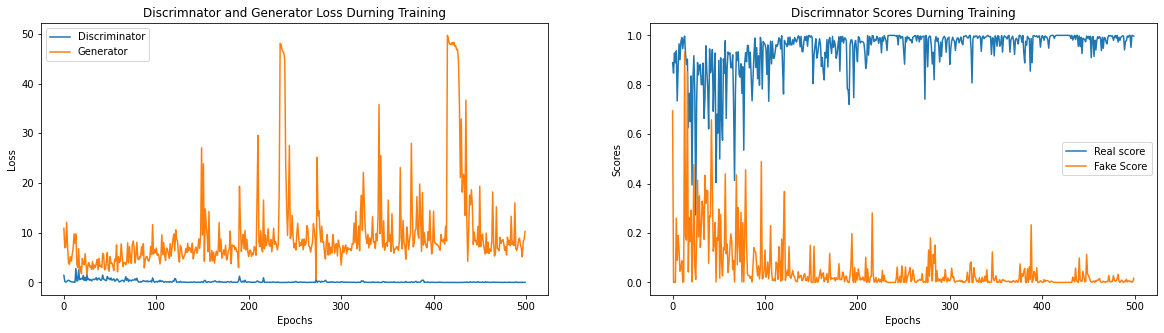

In [27]:
# ploting the loss and score curves
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(dis_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title('Discrimnator and Generator Loss Durning Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(real_scores, label='Real score')
plt.plot(fake_scores, label='Fake Score')
plt.title('Discrimnator Scores Durning Training')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend();

Watching both the charts, we can see that the Generator had a significant improvement durning the 100th, both the plots show a deep stretch durning those epochs.

In the loss plot, discriminator at the end of the 100 epoch shows sign of improving and noticing the fake images better, so most likly if we train for more generator will start to learn something new and create much better images.

Now, lets visualize the sample data we collected

### Sample Visualization

In [ ]:
# Visualizing the sample data from directory 'generated'
sample_img_list = [os.path.join(generator_img_dir, f) for f in os.listdir(generator_img_dir) if 'generated' in f]
sample_img_list.sort()
matplotlib.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8, 8))
plt.axis(False)
sample_img = [[plt.imshow(plt.imread(i), animated=True)] for i in sample_img_list]
sample_animation = animation.ArtistAnimation(fig, sample_img, interval=500, repeat_delay=1000, blit=True)
HTML(sample_animation.to_jshtml())